# **LAB 03:** Cluster Analysis of Chicago's Crash Dataset

By 


*  Pearly Paul
*  Harry Wang
*  Rayon Morris

# **Business Understanding**:


> "*Crash data shows information about each traffic crash on city streets within the City of Chicago limits and under the jurisdiction of Chicago Police Department (CPD). Data are shown as is from the electronic crash reporting system (E-Crash) at CPD, excluding any personally identifiable information. Records are added to the data portal when a crash report is finalized or when amendments are made to an existing report in E-Crash. Data from E-Crash are available for some police districts in 2015, but citywide data are not available until September 2017. About half of all crash reports, mostly minor crashes, are self-reported at the police district by the driver(s) involved and the other half are recorded at the scene by the police officer responding to the crash. Many of the crash parameters, including street condition data, weather condition, and posted speed limits, are recorded by the reporting officer based on best available information at the time, but many of these may disagree with posted information or other assessments on road conditions. If any new or updated information on a crash is received, the reporting officer may amend the crash report at a later time. A traffic crash within the city limits for which CPD is not the responding police agency, typically crashes on interstate highways, freeway ramps, and on local roads along the City boundary, are excluded from this dataset.*

> *All crashes are recorded as per the format specified in the Traffic Crash Report, SR1050, of the Illinois Department of Transportation. The crash data published on the Chicago data portal mostly follows the data elements in SR1050 form. The current version of the SR1050 instructions manual with detailed information on each data elements is available here.*

> *As per Illinois statute, only crashes with a property damage value of $1,500 or more or involving bodily injury to any person(s) and that happen on a public roadway and that involve at least one moving vehicle, except bike dooring, are considered reportable crashes. However, CPD records every reported traffic crash event, regardless of the statute of limitations, and hence any formal Chicago crash dataset released by Illinois Department of Transportation may not include all the crashes listed here.*"

> Traffic Crashes - Crashes | City of Chicago | Data Portal." https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if, Accessed 1 Aug. 2022.


> **Goal**: Our goal is to perform clustering analysis on the dataset using different algorithms to gain some valuable insights from this data. We're interested in seeing what groups the data points fall into when we apply these clustering algorithm. 

# **Data Understanding**:

> The combined dataset consists of 150 features and over 1 million objects. There are too many features among all three datasets to list individually. In order to reduce the space needed to address the variables, the links are provided to the source below where the variables and their definitions can be found.

> [Crashes Data Set](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if)

> [Vehicles Data Set](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3)

> [People Data Set](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d)





## **IMPORT LIBRARIES AND DATA**

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
plt.rc("font", size=14)
from sklearn import preprocessing
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from mlxtend.evaluate import feature_importance_permutation
import sys
!{sys.executable} -m pip install apyori
from apyori import apriori
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5974 sha256=892699e2f078d202c4f6a115bfafcdcf04d8d6a5b0d232063b7dce5df1e81df1
  Stored in directory: /root/.cache/pip/wheels/cb/f6/e1/57973c631d27efd1a2f375bd6a83b2a616c4021f24aab84080
Successfully built apyori


In [2]:
## Set area of outputs
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.set_option("display.max_rows", None, "display.max_columns", None)
np.set_printoptions(threshold=np.inf)

In [3]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


# **Data Loading**

In [4]:
## Change Disk to Data location
%cd /gdrive/MyDrive/Data

## Read in data from Google Drive
vehicles = pd.read_csv('Traffic_Crashes_-_Vehicles.csv')
people = pd.read_csv('Traffic_Crashes_-_People.csv')
crashes = pd.read_csv('Traffic_Crashes_-_Crashes.csv')

/gdrive/MyDrive/Data


# **Data Cleaning** 

In [5]:
# Dimension of the raw data 
print(" There are ",vehicles.shape[0] , " rows and ",vehicles.shape[1] , " columns in the vehicles dataset")
print(" There are ",people.shape[0] , " rows and ",people.shape[1] , " columns in the people dataset")
print(" There are ",crashes.shape[0] , " rows and ",crashes.shape[1] , " columns in the crashes dataset")


 There are  1280586  rows and  72  columns in the vehicles dataset
 There are  1379727  rows and  30  columns in the people dataset
 There are  628379  rows and  49  columns in the crashes dataset


First, we combined all 3 datasets (Crashes, People, and Vehicles) for our Data Analysis. The variables used were: CRASH_RECORD_ID, CRASH_UNIT_ID, and VEHICLE_ID.

> Definitions: 

> * CRASH_RECORD_ID: This number can be used to link to the same crash in the Crashes and Vehicles datasets. This number also serves as a unique ID in the Crashes dataset.
> * CRASH_UNIT_ID: A unique identifier for each vehicle record. 
> * VEHICLE_ID: The corresponding CRASH_UNIT_ID from the Vehicles dataset.



## DATA PREPROCESSING

In [6]:
merged = pd.merge(left=crashes, right = vehicles, left_on='CRASH_RECORD_ID', right_on="CRASH_RECORD_ID")
df_merged = pd.merge(left=merged, right=people, left_on = 'CRASH_UNIT_ID', right_on='VEHICLE_ID')
print(df_merged.shape)
df_merged.head()

(1263056, 150)


,CRASH_RECORD_ID_x,RD_NO_x,CRASH_DATE_EST_I,CRASH_DATE_x,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_UNIT_ID,RD_NO_y,CRASH_DATE_y,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID_x,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,TOWED_I,FIRE_I,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO,ILCC_NO,COMMERCIAL_SRC,GVWR,CARRIER_NAME,CARRIER_STATE,CARRIER_CITY,HAZMAT_PLACARDS_I,HAZMAT_NAME,UN_NO,HAZMAT_PRESENT_I,HAZMAT_REPORT_I,HAZMAT_REPORT_NO,MCS_REPORT_I,MCS_REPORT_NO,HAZMAT_VIO_CAUSE_CRASH_I,MCS_VIO_CAUSE_CRASH_I,IDOT_PERMIT_NO,WIDE_LOAD_I,TRAILER1_WIDTH,TRAILER2_WIDTH,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID_y,RD_NO,VEHICLE_ID_y,CRASH_DATE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,016eaf0b25d64bf0917f77ad2c7468196178eaea750a5fc2a729adde6fc6325f1f252a20dc46f6ed40746b961a7645cb2d3a0391777f2363214f9f54639ac611,JE287447,NaN,07/02/2021 03:40:00 PM,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",07/02/2021 03:45:00 PM,FAILING TO YIELD RIGHT-OF-WAY,IMPROPER OVERTAKING/PASSING,4760,W,76TH ST,833.0,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,15,6,7,NaN,NaN,NaN,1138383,JE287447,07/02/2021 03:40:00 PM,1,DRIVER,NaN,1079791.0,NaN,INFINITI,G37,IL,2008.0,NONE,PASSENGER,PERSONAL,W,MERGING,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,Y,Y,NaN,NaN,ROOF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P268812,PASSENGER,9391a330ce8ef15c41f43eef55c47fb964817aae2e84d8e1dd65e9fa6d8bc08e85fbe1be0bfc0455638e0ada525cbaceb5d4efad32ab77308400d179822bf37b,JE400632,1138383.0,10/06/2021 06:45:00 PM,3.0,MELROSE PARL,IL,60160,M,NaN,NaN,NaN,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,REFUSED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,016eaf0b25d64bf0917f77ad2c7468196178eaea750a5fc2a729adde6fc6325f1f252a20dc46f6ed40746b961a7645cb2d3a0391777f2363214f9f54639ac611,JE287447,NaN,07/02/2021 03:40:00 PM,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",07/02/2021 03:45:00 PM,FAILING TO YIELD RIGHT-OF-WAY,IMPROPER OVERTAKING/PASSING,4760,W,76TH ST,833.0,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,15,6,7,NaN,NaN,NaN,1138383,JE287447,07/02/2021 03:40:00 PM,1,DRIVER,NaN,1079791.0,NaN,INFINITI,G37,IL,2008.0,NONE,PASSENGER,PERSONAL,W,MERGING,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,Y

In [7]:
## Missing Data
def MissingHandler(df_merged):
    list_columns=[]
    DataMissing = df_merged.isnull().sum()*100/len(df_merged)
    DataMissingByColumn = pd.DataFrame({'Percentage Nulls':DataMissing})
    DataMissingByColumn.sort_values(by='Percentage Nulls',ascending=False,inplace=True)
    list_columns.append(DataMissingByColumn.index[DataMissingByColumn['Percentage Nulls']>50])
    return list_columns

print("Features with more than 50% of missing values are: " ,"\n" , MissingHandler(df_merged))

Features with more than 50% of missing values are:  
 [Index(['HAZMAT_REPORT_NO', 'MCS_REPORT_NO', 'PEDPEDAL_VISIBILITY',
       'PEDPEDAL_ACTION', 'PEDPEDAL_LOCATION', 'HAZMAT_NAME',
       'TRAILER2_LENGTH', 'WIDE_LOAD_I', 'HAZMAT_PLACARDS_I', 'TRAILER2_WIDTH',
       'UN_NO', 'IDOT_PERMIT_NO', 'HAZMAT_CLASS', 'FIRE_I', 'CELL_PHONE_USE',
       'ILCC_NO', 'BAC_RESULT VALUE', 'CCMC_NO', 'WORKERS_PRESENT_I',
       'TRAILER1_LENGTH', 'TRAILER1_WIDTH', 'TOTAL_VEHICLE_LENGTH',
       'EXCEED_SPEED_LIMIT_I', 'AXLE_CNT', 'DOORING_I', 'WORK_ZONE_TYPE',
       'WORK_ZONE_I', 'GVWR', 'USDOT_NO', 'HAZMAT_OUT_OF_SERVICE_I',
       'COMMERCIAL_SRC', 'MCS_VIO_CAUSE_CRASH_I', 'MCS_OUT_OF_SERVICE_I',
       'HAZMAT_REPORT_I', 'MCS_REPORT_I', 'HAZMAT_VIO_CAUSE_CRASH_I',
       'HAZMAT_PRESENT_I', 'LOAD_TYPE', 'CARGO_BODY_TYPE', 'VEHICLE_CONFIG',
       'CARRIER_CITY', 'CARRIER_STATE', 'CARRIER_NAME', 'CMV_ID',
       'PHOTOS_TAKEN_I', 'EMS_RUN_NO', 'CMRC_VEH_I', 'STATEMENTS_TAKEN_I',
       'AREA_00

> The columns in the output of the above code block are columns with over 50% of missing data. We'll drop these columns from our Analysis in the next block of code as they do not have enough information to add to our analysis.

> Additionally, we'll also remove the columns that were duplicated during the merger process. As well as columns that added no value to our intended Goal. These were:

> * CRASH_RECORD_ID_x
> * RD_NO_x
> * CRASH_DATE_x
> * DATE_POLICE_NOTIFIED
> * BEAT_OF_OCCURENCE
> * STREET_NO
> * STREET_NAME
> * RD_NO_y
> * CRASH_DATE_y
> * VEHICLE_ID_x
> * CRASH_RECORD_ID_y
> * VEHICLE_ID_y
> * PERSON_ID




In [8]:
## Drop Columns
def data_delete_column(dataset, column_list):  
  for column in column_list:
    dataset.drop([column], axis=1, inplace=True)

df_empty=['HAZMAT_REPORT_NO', 'MCS_REPORT_NO', 'PEDPEDAL_VISIBILITY','DATE_POLICE_NOTIFIED','BEAT_OF_OCCURRENCE','CRASH_DATE_y',
          'UNIT_NO','INJURIES_UNKNOWN','STREET_NO','STREET_NAME','CRASH_UNIT_ID','CRASH_DATE_x',
       'PEDPEDAL_ACTION', 'PEDPEDAL_LOCATION', 'HAZMAT_NAME',
       'TRAILER2_LENGTH', 'WIDE_LOAD_I', 'HAZMAT_PLACARDS_I', 'TRAILER2_WIDTH',
       'UN_NO', 'IDOT_PERMIT_NO', 'HAZMAT_CLASS', 'FIRE_I', 'CELL_PHONE_USE',
       'ILCC_NO', 'BAC_RESULT VALUE', 'CCMC_NO', 'WORKERS_PRESENT_I',
       'TRAILER1_LENGTH', 'TRAILER1_WIDTH', 'TOTAL_VEHICLE_LENGTH',
       'EXCEED_SPEED_LIMIT_I', 'AXLE_CNT', 'DOORING_I', 'WORK_ZONE_TYPE','ZIPCODE',
       'WORK_ZONE_I', 'GVWR', 'USDOT_NO', 'HAZMAT_OUT_OF_SERVICE_I',
       'COMMERCIAL_SRC', 'MCS_VIO_CAUSE_CRASH_I', 'MCS_OUT_OF_SERVICE_I',
       'HAZMAT_REPORT_I', 'MCS_REPORT_I', 'HAZMAT_VIO_CAUSE_CRASH_I',
       'HAZMAT_PRESENT_I', 'LOAD_TYPE', 'CARGO_BODY_TYPE', 'VEHICLE_CONFIG',
       'CARRIER_CITY', 'CARRIER_STATE', 'CARRIER_NAME', 'CMV_ID',
       'PHOTOS_TAKEN_I', 'EMS_RUN_NO', 'CMRC_VEH_I', 'STATEMENTS_TAKEN_I','BAC_RESULT',
       'AREA_00_I', 'NOT_RIGHT_OF_WAY_I', 'AREA_09_I', 'TOWED_TO',
       'CRASH_DATE_EST_I', 'AREA_10_I', 'TOWED_BY', 'AREA_03_I', 'AREA_04_I',
       'EMS_AGENCY', 'AREA_99_I', 'TOWED_I', 'AREA_07_I', 'AREA_12_I','CRASH_RECORD_ID_y','CRASH_RECORD_ID_x','INJURY_CLASSIFICATION',
       'AREA_11_I', 'NUM_PASSENGERS', 'AREA_05_I', 'AREA_06_I', 'AREA_08_I','RD_NO_y','VEHICLE_ID_y',
       'AREA_02_I', 'HOSPITAL', 'SEAT_NO', 'INTERSECTION_RELATED_I','RD_NO_x','VEHICLE_ID_x','RD_NO',
       'AREA_01_I', 'HIT_AND_RUN_I', 'LANE_CNT','PERSON_ID']

data_delete_column(df_merged, df_empty)

> We then removed all null values from the remaining dataset. We have a lot of records initially so removing N/A values will not affect the analysis.

In [273]:
df_crash=df_merged.dropna()
df_crash.isna().sum()

POSTED_SPEED_LIMIT               0
TRAFFIC_CONTROL_DEVICE           0
DEVICE_CONDITION                 0
WEATHER_CONDITION                0
LIGHTING_CONDITION               0
FIRST_CRASH_TYPE                 0
TRAFFICWAY_TYPE                  0
ALIGNMENT                        0
ROADWAY_SURFACE_COND             0
ROAD_DEFECT                      0
REPORT_TYPE                      0
CRASH_TYPE                       0
DAMAGE                           0
PRIM_CONTRIBUTORY_CAUSE          0
SEC_CONTRIBUTORY_CAUSE           0
STREET_DIRECTION                 0
NUM_UNITS                        0
MOST_SEVERE_INJURY               0
INJURIES_TOTAL                   0
INJURIES_FATAL                   0
INJURIES_INCAPACITATING          0
INJURIES_NON_INCAPACITATING      0
INJURIES_REPORTED_NOT_EVIDENT    0
INJURIES_NO_INDICATION           0
CRASH_HOUR                       0
CRASH_DAY_OF_WEEK                0
CRASH_MONTH                      0
LATITUDE                         0
LONGITUDE           

In [274]:
def value_counts1(df):
  cols=list(df.columns)
  for i in cols:
    print(i)
    print(df[i].value_counts())
    print('\n') 

value_counts1(df_crash)

POSTED_SPEED_LIMIT
30    337791
35     31914
25     26599
20     17042
15     14416
10      8909
0       5470
40      4372
5       2830
45      2765
55       342
3        105
50        92
99        66
9         53
39        45
1         25
24        23
60        14
32        13
34        10
33         9
2          9
6          6
65         5
36         4
7          4
11         4
14         4
23         2
12         2
38         2
4          2
49         1
22         1
63         1
29         1
62         1
18         1
31         1
70         1
Name: POSTED_SPEED_LIMIT, dtype: int64


TRAFFIC_CONTROL_DEVICE
NO CONTROLS                 253010
TRAFFIC SIGNAL              133088
STOP SIGN/FLASHER            47271
UNKNOWN                      13391
OTHER                         2543
LANE USE MARKING              1022
YIELD                          642
OTHER REG. SIGN                471
OTHER WARNING SIGN             351
RAILROAD CROSSING GATE         254
PEDESTRIAN CROSSING SIGN       182

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



PASSENGER                               312252
SPORT UTILITY VEHICLE (SUV)              64026
VAN/MINI-VAN                             23917
PICKUP                                   14088
UNKNOWN/NA                               12912
TRUCK - SINGLE UNIT                       8309
BUS OVER 15 PASS.                         4970
OTHER                                     4609
TRACTOR W/ SEMI-TRAILER                   3947
BUS UP TO 15 PASS.                        1061
MOTORCYCLE (OVER 150CC)                   1002
OTHER VEHICLE WITH TRAILER                 575
TRACTOR W/O SEMI-TRAILER                   570
SINGLE UNIT TRUCK WITH TRAILER             412
MOTOR DRIVEN CYCLE                         118
AUTOCYCLE                                   96
MOPED OR MOTORIZED BICYCLE                  55
ALL-TERRAIN VEHICLE (ATV)                   24
3-WHEELED MOTORCYCLE (2 REAR WHEELS)        10
FARM EQUIPMENT                               4
Name: VEHICLE_TYPE, dtype: int64


VEHICLE_USE
PERSONAL     

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



DID NOT DEPLOY                            315846
NOT APPLICABLE                             83763
DEPLOYMENT UNKNOWN                         20107
DEPLOYED, FRONT                            17701
DEPLOYED, COMBINATION                      10877
DEPLOYED, SIDE                              4434
DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)       229
Name: AIRBAG_DEPLOYED, dtype: int64


EJECTION
NONE                  444668
UNKNOWN                 6441
TOTALLY EJECTED         1247
PARTIALLY EJECTED        349
TRAPPED/EXTRICATED       252
Name: EJECTION, dtype: int64


DRIVER_ACTION
NONE                                 206170
UNKNOWN                               73912
OTHER                                 43436
FAILED TO YIELD                       42036
FOLLOWED TOO CLOSELY                  27703
IMPROPER TURN                         11794
IMPROPER BACKING                      11776
IMPROPER LANE CHANGE                  10721
IMPROPER PASSING                       7296
TOO FAST FOR CONDITIONS 

> The above output provides the unique values and their individual counts within each attribute (features). We'll use this information to combine the values in order to reduce the levels within the Categorical variables. This improves the onehot encoding and label encoding that we'll perform.

In [275]:
# Get names of indexes for which column Posted speed limit is less than 20
indexNames = df_crash[df_crash['POSTED_SPEED_LIMIT'] <20].index
df_crash.drop(indexNames , inplace=True)
df_crash['POSTED_SPEED_LIMIT'] = pd.cut(x=df_crash['POSTED_SPEED_LIMIT'], bins = [15,40,60,120], 
                         labels = ['20-40', '41-60', '61+'])
df_crash['POSTED_SPEED_LIMIT'].value_counts()

20-40    417829
41-60      3214
61+          74
Name: POSTED_SPEED_LIMIT, dtype: int64


> We removed any Posted Speed limit under 20 miles per hour.

> And grouped the Posted Speed limit into categorical variables of 20-40, 41-60, 61+.

In [276]:
SEVERITY = {'NO INDICATION OF INJURY':'NO INJURY',
'NONINCAPACITATING INJURY':'INJURY',
'REPORTED, NOT EVIDENT':'INJURY',
'INCAPACITATING INJURY':'INJURY',
'FATAL':'INJURY'
}
                 
                    
df_crash.MOST_SEVERE_INJURY= df_crash.MOST_SEVERE_INJURY.map(SEVERITY)
df_crash.MOST_SEVERE_INJURY.value_counts()

NO INJURY    363161
INJURY        57956
Name: MOST_SEVERE_INJURY, dtype: int64

> We reduced the levels of Severity from 4 down to 2. Namely, No Injury and Injury.

In [277]:
# defining dictionary map and remapping 
traffic_control_map = {'NO CONTROLS':'NO CONTROLS',
'TRAFFIC SIGNAL':'TRAFFIC SIGNAL/SIGN',
'STOP SIGN/FLASHER':'TRAFFIC SIGNAL/SIGN',
'UNKNOWN':'UNKNOWN/OTHER',
'OTHER':'UNKNOWN/OTHER',
'LANE USE MARKING':'TRAFFIC SIGNAL/SIGN',
'YIELD':'TRAFFIC SIGNAL/SIGN',
'OTHER REG. SIGN':'TRAFFIC SIGNAL/SIGN',
'OTHER WARNING SIGN':'TRAFFIC SIGNAL/SIGN',
'RAILROAD CROSSING GATE':'TRAFFIC SIGNAL/SIGN',
'PEDESTRIAN CROSSING SIGN':'TRAFFIC SIGNAL/SIGN',
'POLICE/FLAGMAN':'TRAFFIC SIGNAL/SIGN',
'SCHOOL ZONE':'TRAFFIC SIGNAL/SIGN',
'DELINEATORS':'TRAFFIC SIGNAL/SIGN',
'FLASHING CONTROL SIGNAL':'TRAFFIC SIGNAL/SIGN',
'OTHER RAILROAD CROSSING':'TRAFFIC SIGNAL/SIGN',
'RR CROSSING SIGN':'TRAFFIC SIGNAL/SIGN',
'NO PASSING':'TRAFFIC SIGNAL/SIGN',
'BICYCLE CROSSING SIGN':'TRAFFIC SIGNAL/SIGN'}
                 
                    
df_crash.TRAFFIC_CONTROL_DEVICE= df_crash.TRAFFIC_CONTROL_DEVICE.map(traffic_control_map)
df_crash.TRAFFIC_CONTROL_DEVICE.value_counts()

NO CONTROLS            225156
TRAFFIC SIGNAL/SIGN    181034
UNKNOWN/OTHER           14927
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64

> We reduced the levels of Traffic Control device to 3.

In [278]:
# defining dictionary map and remapping 
device_condition_1 = {'NO CONTROLS':'NO CONTROLS','MISSING':'NO CONTROLS','UNKNOWN':'UNKNOWN/OTHER','OTHER':'UNKNOWN/OTHER',
                       
'FUNCTIONING PROPERLY':'PROPER_FUNCTIONING','FUNCTIONING IMPROPERLY':'IMPROPER_FUNCTIONING','NOT FUNCTIONING':'IMPROPER_FUNCTIONING',
'WORN REFLECTIVE MATERIAL':'IMPROPER_FUNCTIONING'}
                    
df_crash.DEVICE_CONDITION= df_crash.DEVICE_CONDITION.map(device_condition_1)
df_crash.DEVICE_CONDITION.value_counts()
df_crash.DEVICE_CONDITION.unique()

NO CONTROLS             228386
PROPER_FUNCTIONING      162740
UNKNOWN/OTHER            25976
IMPROPER_FUNCTIONING      4015
Name: DEVICE_CONDITION, dtype: int64

array(['UNKNOWN/OTHER', 'PROPER_FUNCTIONING', 'NO CONTROLS',
       'IMPROPER_FUNCTIONING'], dtype=object)

> We reduced the levels of Device Condition to 4.

In [279]:

WEATHER_CONDITION_MAP = {'CLEAR': 'IDEAL','CLOUDY/OVERCAST':'NOT IDEAL',
                'RAIN': 'NOT IDEAL','SNOW':'NOT IDEAL',
                'FOG/SMOKE/HAZE':'NOT IDEAL',
                'FREEZING RAIN/DRIZZLE':'NOT IDEAL',
                'SLEET/HAIL':'SEVERE',
                'UNKNOWN':'UNKNOWN/OTHER','OTHER':'UNKNOWN/OTHER',
                'BLOWING SNOW':'SEVERE',
                'SEVERE CROSS WIND GATE':'SEVERE',
                'BLOWING SAND, SOIL, DIRT':'SEVERE'}


df_crash.WEATHER_CONDITION = df_crash.WEATHER_CONDITION.map(WEATHER_CONDITION_MAP)
df_crash.WEATHER_CONDITION.value_counts()

df_crash.WEATHER_CONDITION.unique()

IDEAL            335125
NOT IDEAL         68918
UNKNOWN/OTHER     16197
SEVERE              877
Name: WEATHER_CONDITION, dtype: int64

array(['IDEAL', 'NOT IDEAL', 'UNKNOWN/OTHER', 'SEVERE'], dtype=object)

> We reduced the levels of Weather Condition to 4.

In [280]:
LIGHTING_CONDITION_MAP = {'DAYLIGHT': 'DAYLIGHT',
                'DARKNESS, LIGHTED ROAD': 'DARKNESS','DARKNESS':'DARKNESS','DUSK':'DAYLIGHT','DAWN':'DARKNESS',
                'UNKNOWN':'UNKNOWN/OTHER'}

df_crash.LIGHTING_CONDITION = df_crash.LIGHTING_CONDITION.map(LIGHTING_CONDITION_MAP)
df_crash.LIGHTING_CONDITION.value_counts()

DAYLIGHT         288282
DARKNESS         121105
UNKNOWN/OTHER     11730
Name: LIGHTING_CONDITION, dtype: int64

> We reduced the levels of Lighting Condition to 3.

In [281]:
                           
# defining dictionary map and remapping
crash_map = {'REAR END':'REAR COLLISION',
'PARKED MOTOR VEHICLE':'PARKED/FIXED',
'SIDESWIPE SAME DIRECTION':'SIDE COLLISION',
'TURNING':'TURNING/ANGLE',
'ANGLE':'TURNING/ANGLE',
'FIXED OBJECT':'PARKED/FIXED',
'SIDESWIPE OPPOSITE DIRECTION':'SIDE COLLISION',
'PEDESTRIAN':'PED/CYCLIST',
'HEAD ON':'FRONT-COLLISION',
'REAR TO FRONT':'REAR-COLLISIONS',
'PEDALCYCLIST':'PED/CYCLIST',
'OTHER OBJECT':'NON-VEHICLE-COLLISION',
'REAR TO SIDE':'REAR-COLLISIONS',
'REAR TO REAR':'REAR-COLLISIONS',
'OTHER NONCOLLISION':'NON-VEHICLE-COLLISION',
'ANIMAL':'NON-VEHICLE-COLLISION',
'OVERTURNED':'TURNING/ANGLE',
'TRAIN':'NON-VEHICLE-COLLISION'
}


df_crash.FIRST_CRASH_TYPE.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df_crash.FIRST_CRASH_TYPE = df_crash.FIRST_CRASH_TYPE.map(crash_map)
df_crash.FIRST_CRASH_TYPE.unique()

array(['TURNING/ANGLE', 'REAR COLLISION', 'PARKED/FIXED',
       'SIDE COLLISION', 'PED/CYCLIST', 'FRONT-COLLISION',
       'REAR-COLLISIONS', 'NON-VEHICLE-COLLISION'], dtype=object)

> We reduced the levels of First Crash Type (Type of first collision in crash) to 8.

In [282]:
# defining dictionary map and remapping
traffic_map = {'NOT DIVIDED': 'NOT DIVIDED',
                'DIVIDED - W/MEDIAN (NOT RAISED)':'DIVIDED',
                'ONE-WAY':'ONE-WAY',
                'FOUR WAY': 'FOUR WAY','FIVE POINT, OR MORE':'INTERSECTION','DRIVEWAY':'DRIVEWAY/RAMP','RAMP':'DRIVEWAY/RAMP','TRAFFIC ROUTE':'NOT DIVIDED',
                'PARKING LOT': 'PARKING LOT',
                'DIVIDED - W/MEDIAN BARRIER':'DIVIDED',
                'ALLEY': 'ALLEY',
                'OTHER': 'UNKNOWN/OTHER',
                'CENTER TURN LANE': 'INTERSECTION',
                'Y-INTERSECTION': 'INTERSECTION',
                'T-INTERSECTION': 'INTERSECTION',
                'UNKNOWN': 'UNKNOWN/OTHER',
                'NOT REPORTED': 'UNKNOWN/OTHER',
               'ROUNDABOUT':'ROUND WAY',
               'L-INTERSECTION':'INTERSECTION',
                'UNKNOWN INTERSECTION TYPE': 'INTERSECTION'}

df_crash.TRAFFICWAY_TYPE = df_crash.TRAFFICWAY_TYPE.map(traffic_map)
df_crash.TRAFFICWAY_TYPE.value_counts()
df_crash.TRAFFICWAY_TYPE.unique()

NOT DIVIDED      200773
DIVIDED          106673
ONE-WAY           54242
FOUR WAY          19230
UNKNOWN/OTHER     13581
PARKING LOT       11850
INTERSECTION       9853
ALLEY              2836
DRIVEWAY/RAMP      2004
ROUND WAY            75
Name: TRAFFICWAY_TYPE, dtype: int64

array(['NOT DIVIDED', 'FOUR WAY', 'DIVIDED', 'ONE-WAY', 'ALLEY',
       'PARKING LOT', 'INTERSECTION', 'UNKNOWN/OTHER', 'DRIVEWAY/RAMP',
       'ROUND WAY'], dtype=object)

> > We reduced the levels of TrafficWay Type to 9.

In [283]:
# defining dictionary map and remapping
ALIGNMENT_map = {'STRAIGHT AND LEVEL': 'STRAIGHT','STRAIGHT ON GRADE':'STRAIGHT',
               'CURVE, LEVEL': 'CURVE','STRAIGHT ON HILLCREST':'STRAIGHT','CURVE ON GRADE':'CURVE','CURVE ON HILLCREST':'CURVE'}


df_crash.ALIGNMENT = df_crash.ALIGNMENT.map(ALIGNMENT_map)
df_crash.ALIGNMENT.value_counts()

STRAIGHT    417628
CURVE         3489
Name: ALIGNMENT, dtype: int64

> We reduced the levels of Alignment to 2.

In [284]:
# defining dictionary map and remapping
ROADWAY_SURFACE_COND_map = {'DRY': 'DRY','WET':'SLIPPERY','UNKNOWN':'UNKNOWN/OTHER','OTHER':'UNKNOWN/OTHER',
                            'SNOW OR SLUSH':'ICY/FROZEN','ICE':'ICY/FROZEN','SAND, MUD, DIRT':'SLIPPERY'}

df_crash.ROADWAY_SURFACE_COND = df_crash.ROADWAY_SURFACE_COND.map(ROADWAY_SURFACE_COND_map)
df_crash.ROADWAY_SURFACE_COND.value_counts()

DRY              315815
SLIPPERY          59523
UNKNOWN/OTHER     25927
ICY/FROZEN        19852
Name: ROADWAY_SURFACE_COND, dtype: int64

>  We reduced the levels of ROADWAY_SURFACE_COND to 4 levels.

In [285]:

defect_map = {'NO DEFECTS': 'NO DEFECTS',
                'UNKNOWN': 'UNKNOWN/OTHER',
                'OTHER': 'UNKNOWN/OTHER',
                'RUT, HOLES': 'ROAD DEFECTS',
                'DEBRIS ON ROADWAY' : 'ROAD DEFECTS',
                'WORN SURFACE':'ROAD DEFECTS',
              'SHOULDER DEFECT':'ROAD DEFECTS'}

df_crash.ROAD_DEFECT = df_crash.ROAD_DEFECT.map(defect_map)
df_crash.ROAD_DEFECT.value_counts()

NO DEFECTS       351832
UNKNOWN/OTHER     63778
ROAD DEFECTS       5507
Name: ROAD_DEFECT, dtype: int64

>  We reduced the levels of ROAD Defect to 3 levels.

In [286]:
new_lis1 = ['NOT APPLICABLE', 
'FAILING TO REDUCE SPEED TO AVOID CRASH',
'ROAD CONSTRUCTION/MAINTENANCE',
'UNABLE TO DETERMINE',
'IMPROPER TURNING/NO SIGNAL', 
'EQUIPMENT - VEHICLE CONDITION',
'FAILING TO YIELD RIGHT-OF-WAY',
'FOLLOWING TOO CLOSELY',
'IMPROPER LANE USAGE',
 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
'IMPROPER OVERTAKING/PASSING', 
'DISREGARDING TRAFFIC SIGNALS',
'DISTRACTION - FROM OUTSIDE VEHICLE', 
'WEATHER',
'IMPROPER BACKING', 
'EXCEEDING SAFE SPEED FOR CONDITIONS',
'DISTRACTION - FROM INSIDE VEHICLE',
'DISREGARDING YIELD SIGN',
'DISREGARDING STOP SIGN', 
'DRIVING ON WRONG SIDE/WRONG WAY',
'DISREGARDING OTHER TRAFFIC SIGNS',
 'PHYSICAL CONDITION OF DRIVER',
'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)',
'EXCEEDING AUTHORIZED SPEED LIMIT',
'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)',
'DISREGARDING ROAD MARKINGS',
'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
'CELL PHONE USE OTHER THAN TEXTING',
'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)',
'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)',
'ROAD ENGINEERING/SURFACE/MARKING DEFECTS', 
'TURNING RIGHT ON RED',
'ANIMAL', 
'BICYCLE ADVANCING LEGALLY ON RED LIGHT', 
'TEXTING',
'RELATED TO BUS STOP', 
'OBSTRUCTED CROSSWALKS',
'PASSING STOPPED SCHOOL BUS',
'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT']

new_lis2 = ['UNABLE TO DETERMINED',
'DRIVER-ERROR',
'DRIVER-ERROR',
'DRIVER-ERROR',
'DRIVER-ERROR',
'DRIVER-ERROR',
'UNKNOWN/OTHER',
'DRIVER-ERROR',
'DRIVER-ERROR',
'DRIVER-ERROR',
'RECKLESS DRIVER',
'ROAD DEFECT',
'RECKLESS DRIVER',
'RECKLESS DRIVER',
'RECKLESS DRIVER',
'RECKLESS DRIVER',
'VECHICLE DEFECT',
'RECKLESS DRIVER',
'ROAD DEFECT',
'RECKLESS DRIVER',
'RECKLESS DRIVER',
'RECKLESS DRIVER',
'RECKLESS DRIVER',
'RECKLESS DRIVER',
'ROAD DEFECT',
'ROAD DEFECT',
'ROAD DEFECT',
'RECKLESS DRIVER',
'RECKLESS DRIVER',
'RECKLESS DRIVER',
'ROAD DEFECT',
'DRIVER-ERROR',
'RECKLESS DRIVER',
'RECKLESS DRIVER',
'DRIVER-ERROR',
'RECKLESS DRIVER',
'RECKLESS DRIVER',
'DRIVER-ERROR',
'ROAD DEFECT',
'DRIVER-ERROR']
new_dict = {new_lis1[i]: new_lis2[i] for i in range(len(new_lis1))}
df_crash.PRIM_CONTRIBUTORY_CAUSE= df_crash.PRIM_CONTRIBUTORY_CAUSE.map(new_dict)
df_crash.PRIM_CONTRIBUTORY_CAUSE.value_counts()

DRIVER-ERROR            265677
RECKLESS DRIVER          63624
UNKNOWN/OTHER            49839
ROAD DEFECT              20076
UNABLE TO DETERMINED     18181
VECHICLE DEFECT           3720
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64

>  We reduced the levels of PRIM Contributory Cause to 6 levels.

In [287]:
new_lis1=['UNKNOWN', 'NONE', 'OTHER', 'STEERING', 'BRAKES', 'SUSPENSION',
       'TIRES', 'ENGINE/MOTOR', 'WHEELS', 'LIGHTS', 'TRAILER COUPLING',
       'WINDOWS', 'EXHAUST', 'FUEL SYSTEM', 'CARGO', 'SIGNALS',
       'RESTRAINT SYSTEM']
new_lis2=['NO DEFECT',
'UNKNOWN/OTHER',
'UNKNOWN/OTHER',
'DEFECT',
'DEFECT',
'DEFECT',
'DEFECT',
'DEFECT',
'DEFECT',
'DEFECT',
'DEFECT',
'DEFECT',
'DEFECT',
'DEFECT',
'DEFECT',
'DEFECT',
'DEFECT']

new_dict = {new_lis1[i]: new_lis2[i] for i in range(len(new_lis1))}
df_crash.VEHICLE_DEFECT= df_crash.VEHICLE_DEFECT.map(new_dict)
df_crash.VEHICLE_DEFECT.value_counts()

UNKNOWN/OTHER    270353
NO DEFECT        148305
DEFECT             2459
Name: VEHICLE_DEFECT, dtype: int64

>  We reduced the levels of Vehicle Defect to 3 levels.

In [288]:

df_crash['CRASH_HOUR'] = pd.cut(x=df_crash['CRASH_HOUR'], bins = [-1,6,12,18,24], 
                         labels = ['Early_Morning', 
                        'Morning', 'Afternoon','Late_Evening'])
df_crash.CRASH_HOUR.unique()

['Morning', 'Late_Evening', 'Afternoon', 'Early_Morning']
Categories (4, object): ['Early_Morning' < 'Morning' < 'Afternoon' < 'Late_Evening']

>  We reduced the levels of CRASH HOUR to 4 levels.

In [289]:
df_crash['CRASH_DAY_OF_WEEK'] = pd.cut(x=df_crash['CRASH_DAY_OF_WEEK'], bins = [0,5,8], labels = ['WEEKDAY','WEEKEND'])
df_crash['CRASH_DAY_OF_WEEK'].value_counts()


df_crash.CRASH_DAY_OF_WEEK.unique()

WEEKDAY    289914
WEEKEND    131203
Name: CRASH_DAY_OF_WEEK, dtype: int64

['WEEKDAY', 'WEEKEND']
Categories (2, object): ['WEEKDAY' < 'WEEKEND']

>  We converted the days of Crash Day of Week into the Weekday and the Weekend.

In [290]:
df_crash['DRIVERS_LICENSE_STATE'].loc[(df_crash['DRIVERS_LICENSE_STATE'] !='IL' )] = 'OTHER-STATE-DRIVER'
df_crash['DRIVERS_LICENSE_STATE'].loc[(df_crash['DRIVERS_LICENSE_STATE'] =='IL' )] = 'IN-STATE-DRIVER'
df_crash['DRIVERS_LICENSE_STATE'].value_counts()
df_crash.DRIVERS_LICENSE_STATE.unique()

IN-STATE-DRIVER       402292
OTHER-STATE-DRIVER     18825
Name: DRIVERS_LICENSE_STATE, dtype: int64

array(['IN-STATE-DRIVER', 'OTHER-STATE-DRIVER'], dtype=object)

> We reduced the levels of Drivers License State to 2 levels

In [291]:
df_crash['LIC_PLATE_STATE'].loc[(df_crash['LIC_PLATE_STATE'] !='IL' )] = 'OTHER-STATE-CAR'
df_crash['LIC_PLATE_STATE'].loc[(df_crash['LIC_PLATE_STATE'] =='IL' )] = 'IN-STATE-CAR'
df_crash['LIC_PLATE_STATE'].value_counts()

df_crash.LIC_PLATE_STATE.unique()

IN-STATE-CAR       395298
OTHER-STATE-CAR     25819
Name: LIC_PLATE_STATE, dtype: int64

array(['IN-STATE-CAR', 'OTHER-STATE-CAR'], dtype=object)

> We reduced the levels of LICENSE PLATE STATE to 2 levels.

In [292]:
new_lis1=['UNKNOWN/NA', 'PERSONAL', 'RIDESHARE SERVICE', 'NOT IN USE',
       'POLICE', 'OTHER', 'MASS TRANSIT', 'COMMERCIAL - MULTI-UNIT',
       'TAXI/FOR HIRE', 'COMMERCIAL - SINGLE UNIT', 'FIRE',
       'OTHER TRANSIT', 'CTA', 'TOW TRUCK', 'DRIVER EDUCATION',
       'AMBULANCE', 'CONSTRUCTION/MAINTENANCE', 'SCHOOL BUS',
       'LAWN CARE/LANDSCAPING', 'AGRICULTURE', 'STATE OWNED',
       'CAMPER/RV - SINGLE UNIT', 'HOUSE TRAILER', 'MILITARY',
       'CAMPER/RV - TOWED/MULTI-UNIT']

new_lis2  =['UNKNOWN/OTHER', 'PERSONAL-USE', 'RIDESHARE/TAX', 'NOT IN USE',
       'GOVERNMENT_USE_VEHICLES', 'UNKNOWN/OTHER', 'GROUP_TRANSIT/BUS','COMMERCIAL - MULTI-UNIT',
       'RIDESHARE/TAXI','COMMERCIAL MULTI/SINGLE UNIT', 'GOVERNMENT_USE_VEHICLES',
       'COMMERCIAL MULTI/SINGLE UNIT', 'GOVERNMENT_USE_VEHICLES', 'GOVERNMENT_USE_VEHICLES',  'COMMERCIAL MULTI/SINGLE UNIT',
       'COMMERCIAL MULTI/SINGLE UNIT',  'COMMERCIAL MULTI/SINGLE UNIT',  'COMMERCIAL MULTI/SINGLE UNIT',
       'COMMERCIAL MULTI/SINGLE UNIT', 'COMMERCIAL MULTI/SINGLE UNIT', 'GOVERNMENT_USE_VEHICLES',
      'CAMPER/RV - TOWED/MULTI-UNIT', 'CAMPER/RV - TOWED/MULTI-UNIT', 'GOVERNMENT_USE_VEHICLES',
      'CAMPER/RV - TOWED/MULTI-UNIT']


new_dict = {new_lis1[i]: new_lis2[i] for i in range(len(new_lis1))}
df_crash.VEHICLE_USE= df_crash.VEHICLE_USE.map(new_dict)
df_crash.VEHICLE_USE.value_counts()
df_crash.VEHICLE_USE.unique()


PERSONAL-USE                    307459
UNKNOWN/OTHER                    58932
NOT IN USE                       22565
COMMERCIAL MULTI/SINGLE UNIT     11400
RIDESHARE/TAXI                    7471
GOVERNMENT_USE_VEHICLES           6898
RIDESHARE/TAX                     4378
COMMERCIAL - MULTI-UNIT           1664
GROUP_TRANSIT/BUS                  319
CAMPER/RV - TOWED/MULTI-UNIT        31
Name: VEHICLE_USE, dtype: int64

array(['UNKNOWN/OTHER', 'PERSONAL-USE', 'RIDESHARE/TAX', 'NOT IN USE',
       'GOVERNMENT_USE_VEHICLES', 'GROUP_TRANSIT/BUS',
       'COMMERCIAL - MULTI-UNIT', 'RIDESHARE/TAXI',
       'COMMERCIAL MULTI/SINGLE UNIT', 'CAMPER/RV - TOWED/MULTI-UNIT'],
      dtype=object)

> We reduced the levels of Vehicle Use to 10 levels.

In [293]:
df_crash['STATE'].loc[(df_crash['STATE'] !='IL' )] = 'OUT-OF-STATE'
df_crash['STATE'].loc[(df_crash['STATE'] =='IL' ) ] = 'IN-STATE'
df_crash['STATE'].value_counts()

IN-STATE        405967
OUT-OF-STATE     15150
Name: STATE, dtype: int64

> We reduced the levels of STATE to 2 levels.

In [294]:
df_crash.SEX.value_counts()

df_crash['SEX'].loc[(df_crash['SEX'] =='M' )] = 'MALE'
df_crash['SEX'].loc[(df_crash['SEX'] =='F' )] = 'FEMALE'
df_crash['SEX'].loc[(df_crash['SEX'] =='X' )] = 'UNKNOWN/OTHER'
df_crash['SEX'].value_counts()

M    250934
F    169779
X       404
Name: SEX, dtype: int64

MALE             250934
FEMALE           169779
UNKNOWN/OTHER       404
Name: SEX, dtype: int64

> We renamed the values to a name more interpretable for our analysis.

In [295]:
# Get names of indexes for which column Age has value 30
indexNames = df_crash[ df_crash['AGE'] <=0 ].index
indexNames1 = df_crash[ df_crash['AGE'] > 80 ].index
# Delete these row indexes from dataFrame
df_crash.drop(indexNames , inplace=True)
df_crash.drop(indexNames1 , inplace=True)

bins = [-1, 14, 24, 64, 90]

bin_labels = ['CHILDREN','YOUTH','ADULTS','SENIOR']
df_crash['AGE'] = pd.cut(x=df_crash['AGE'], bins =bins , 
                         labels = bin_labels)

df_crash['AGE'].value_counts()

df_crash.AGE.unique()

ADULTS      320599
YOUTH        62380
SENIOR       30534
CHILDREN       154
Name: AGE, dtype: int64

['ADULTS', 'YOUTH', 'SENIOR', 'CHILDREN']
Categories (4, object): ['CHILDREN' < 'YOUTH' < 'ADULTS' < 'SENIOR']

> We grouped the ages into categories of Adults, Youth, Senior and Children.

In [296]:
df_crash.columns

# defining dictionary map and remapping
vehicle_map = {'PASSENGER': 'PASSENGER',
               'SPORT UTILITY VEHICLE (SUV)':'SUV/VAN/PICKUP',
               'UNKNOWN/NA':'UNKNOWN/OTHER',
               'OTHER':'UNKNOWN/OTHER',
               'PICKUP': 'SUV/VAN/PICKUP',
               'VAN/MINI-VAN':'SUV/VAN/PICKUP',
               'BUS OVER 15 PASS.':'BUS/TRUCK/TRAILER',
               'TRUCK - SINGLE UNIT':'BUS/TRUCK/TRAILER',
               'TRACTOR W/ SEMI-TRAILER':'BUS/TRUCK/TRAILER',
               'MOTORCYCLE (OVER 150CC)':'MOTOR-2WHEELER',
               'BUS UP TO 15 PASS.':'BUS/TRUCK/TRAILER',
               'OTHER VEHICLE WITH TRAILER':'OTHER VEHICLE WITH TRAILER',
               'AUTOCYCLE':'3-WHEELED MOTORCYCLE (2 REAR WHEELS)',
               'MOTOR DRIVEN CYCLE':'MOTOR-2WHEELER',
              '3-WHEELED MOTORCYCLE (2 REAR WHEELS)':'3-WHEELED MOTORCYCLE (2 REAR WHEELS)',
                'MOPED OR MOTORIZED BICYCLE':'MOTOR-2WHEELER',
               'FARM EQUIPMENT':'BUS/TRUCK/TRAILER',
               'ALL-TERRAIN VEHICLE (ATV)':'BUS/TRUCK/TRAILER'
                }

df_crash.VEHICLE_TYPE = df_crash.VEHICLE_TYPE.map(vehicle_map)
df_crash.VEHICLE_TYPE.value_counts()

Index(['POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
       'REPORT_TYPE', 'CRASH_TYPE', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE',
       'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'LOCATION',
       'UNIT_TYPE', 'MAKE', 'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR',
       'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION',
       'MANEUVER', 'OCCUPANT_CNT', 'FIRST_CONTACT_POINT', 'PERSON_TYPE',
       'CRASH_DATE', 'CITY', 'STATE', 'SEX', 'AGE', 'DRIVERS_LICENSE_STATE',
       'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT'

PASSENGER                               286502
SUV/VAN/PICKUP                           92115
BUS/TRUCK/TRAILER                        16589
UNKNOWN/OTHER                            15834
MOTOR-2WHEELER                            1119
OTHER VEHICLE WITH TRAILER                 526
3-WHEELED MOTORCYCLE (2 REAR WHEELS)       102
Name: VEHICLE_TYPE, dtype: int64

In [297]:
df_merged.VEHICLE_TYPE.unique()

array(['PASSENGER', 'SPORT UTILITY VEHICLE (SUV)', 'PICKUP',
       'BUS OVER 15 PASS.', 'TRUCK - SINGLE UNIT', 'UNKNOWN/NA',
       'VAN/MINI-VAN', 'TRACTOR W/ SEMI-TRAILER', 'OTHER', nan,
       'SINGLE UNIT TRUCK WITH TRAILER', 'BUS UP TO 15 PASS.',
       'OTHER VEHICLE WITH TRAILER', 'TRACTOR W/O SEMI-TRAILER',
       'MOTORCYCLE (OVER 150CC)', 'AUTOCYCLE',
       'MOPED OR MOTORIZED BICYCLE', 'FARM EQUIPMENT',
       'MOTOR DRIVEN CYCLE', 'ALL-TERRAIN VEHICLE (ATV)',
       '3-WHEELED MOTORCYCLE (2 REAR WHEELS)',
       'RECREATIONAL OFF-HIGHWAY VEHICLE (ROV)', 'SNOWMOBILE'],
      dtype=object)

> We reduced the levels of Vehicle type to 6 levels.

In [298]:
def DV(val): 
    if val == 'BLINDED - HEADLIGHTS':
        return 'OBSCURED'
    else:
      if val == 'BLINDED - SUNLIGHT':
        return 'OBSCURED'
      else:
        if val == 'BLOWING MATERIALS':
          return 'OBSCURED'
        else:
          if val == 'BUILDINGS':
            return 'OBSCURED' 
          else:
            if val =='EMBANKMENT':
              return 'OBSCURED'
            else: 
              if val == 'HILLCREST':
                return 'OBSCURED'
              else:
                if val == 'MOVING VEHICLES':
                  return 'OBSCURED'
                else:
                  if val == 'NOT OBSCURED':
                    return 'NOT OBSCURED'
                  else:
                    if val == 'OTHER':
                      return 'OBSCURED'
                    else:
                      if val == 'PARKED VEHICLES':
                        return 'OBSCURED'
                      else:
                        if val == 'SIGNBOARD':
                          return 'OBSCURED'
                        else:
                          if val == 'TREES, PLANTS':
                            return 'OBSCURED'
                          else:
                            if val == 'UNKNOWN':
                              return 'UNKNOWN/OTHER'
                            else:
                              return 'OBSCURED'

df_crash['DRIVER_VISION'] = df_crash['DRIVER_VISION'].map(DV)
df_crash.DRIVER_VISION.value_counts()

NOT OBSCURED     283356
UNKNOWN/OTHER    117267
OBSCURED          13044
Name: DRIVER_VISION, dtype: int64

> We reduced the levels of the Driver Vision to 3 Levels.

In [299]:
def DLSTATE(val): 
    if val == 'DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)':
        return 'DEPLOYED'
    else:
      if val == 'DEPLOYED, COMBINATION':
        return 'DEPLOYED'
      else:
        if val == 'DEPLOYED, FRONT':
          return 'DEPLOYED'
        else:
          if val == 'DEPLOYED, SIDE':
            return 'DEPLOYED' 
          else:
            if val =='DEPLOYMENT UNKNOWN':
              return 'UNKNOWN/OTHER'
            else: 
              if val == 'DID NOT DEPLOY':
                return 'DID NOT DEPLOY'
              else:
                if val == 'NOT APPLICABLE':
                  return 'NOT APPLICABLE'
                  
df_crash['AIRBAG_DEPLOYED'] = df_crash['AIRBAG_DEPLOYED'].map(DLSTATE)

> We reduced the levels of the Airbag Deployed to 4 levels

In [300]:
new_lis1=['NORMAL', 'UNKNOWN', 'REMOVED BY EMS', 'FATIGUED/ASLEEP',
       'IMPAIRED - ALCOHOL', 'OTHER', 'EMOTIONAL', 'ILLNESS/FAINTED',
       'IMPAIRED - DRUGS', 'MEDICATED', 'HAD BEEN DRINKING',
       'IMPAIRED - ALCOHOL AND DRUGS']
new_lis2=['NORMAL','UNKNOWN/OTHER','SICK/FATIGUED/ASLEEP','SICK/FATIGUED/ASLEEP','IMPAIRED - ALCOHOL/DRUG','UNKNOWN/OTHER',
        'SICK/FATIGUED/ASLEEP','SICK/FATIGUED/ASLEEP','IMPAIRED - ALCOHOL/DRUG','SICK/FATIGUED/ASLEEP','IMPAIRED - ALCOHOL/DRUG','IMPAIRED - ALCOHOL/DRUG']


new_dict = {new_lis1[i]: new_lis2[i] for i in range(len(new_lis1))}

df_crash.PHYSICAL_CONDITION= df_crash.PHYSICAL_CONDITION.map(new_dict)
df_crash.PHYSICAL_CONDITION.value_counts()

NORMAL                     355760
UNKNOWN/OTHER               50606
SICK/FATIGUED/ASLEEP         4467
IMPAIRED - ALCOHOL/DRUG      2834
Name: PHYSICAL_CONDITION, dtype: int64

> We reduced the levels of the Physical Condition to 4 levels.

In [301]:
df_crash.SAFETY_EQUIPMENT.unique()

new_lis1= ['SAFETY BELT USED', 'USAGE UNKNOWN', 'NONE PRESENT', 
'SAFETY BELT NOT USED', 'HELMET NOT USED', 'SHOULD/LAP BELT USED IMPROPERLY', 
'HELMET USED', 'DOT COMPLIANT MOTORCYCLE HELMET', 'NOT DOT COMPLIANT MOTORCYCLE HELMET']

new_lis2=['SAFETY/HELMET BELT USED', 'UNKNOWN/OTHER', 'SAFETY EQUIPMENT NOT AVAILABLE',
       'SAFETY/HELMET BELT NOT USED', 'SAFETY/HELMET BELT NOT USED',
       'SAFETY/HELMET BELT NOT USED', 'SAFETY/HELMET BELT USED',
       'SAFETY/HELMET BELT USED',
       'SAFETY/HELMET BELT NOT USED']
     
new_dict = {new_lis1[i]: new_lis2[i] for i in range(len(new_lis1))}

df_crash.SAFETY_EQUIPMENT= df_crash.SAFETY_EQUIPMENT.map(new_dict)
df_crash.SAFETY_EQUIPMENT.value_counts()

array(['SAFETY BELT USED', 'USAGE UNKNOWN', 'NONE PRESENT',
       'SAFETY BELT NOT USED', 'HELMET NOT USED',
       'SHOULD/LAP BELT USED IMPROPERLY', 'HELMET USED',
       'DOT COMPLIANT MOTORCYCLE HELMET',
       'NOT DOT COMPLIANT MOTORCYCLE HELMET'], dtype=object)

SAFETY/HELMET BELT USED           270773
UNKNOWN/OTHER                     131562
SAFETY EQUIPMENT NOT AVAILABLE      8799
SAFETY/HELMET BELT NOT USED         2533
Name: SAFETY_EQUIPMENT, dtype: int64

> We reduced the levels of the Safety Equipment to 4 levels

In [302]:
df_crash.loc[df_crash['INJURIES_TOTAL']>2, 'INJURIES_TOTAL'] ='GREATER THAN 2 INJURIES'
df_crash.loc[df_crash['INJURIES_TOTAL'] == 0, 'INJURIES_TOTAL'] ='NO INJURIES'
df_crash.loc[df_crash['INJURIES_TOTAL'] == 1, 'INJURIES_TOTAL'] ='1-INJURIES'
df_crash.loc[df_crash['INJURIES_TOTAL'] == 2, 'INJURIES_TOTAL'] ='2-INJURIES'

In [303]:
df_crash.loc[df_crash['OCCUPANT_CNT']>3, 'OCCUPANT_CNT'] ='MORE THAN 3 OCCUPANTS'
df_crash.loc[df_crash['OCCUPANT_CNT'] == 0, 'OCCUPANT_CNT'] ='NO OCCUPANTS'
df_crash.loc[df_crash['OCCUPANT_CNT'] == 1, 'OCCUPANT_CNT'] ='1 OCCUPANTS'
df_crash.loc[df_crash['OCCUPANT_CNT'] == 2, 'OCCUPANT_CNT'] ='2-OCCUPANTS'
df_crash.loc[df_crash['OCCUPANT_CNT'] == 3, 'OCCUPANT_CNT'] ='3-OCCUPANTS'

In [304]:
#https://allanbond.medium.com/creating-a-function-to-convert-a-month-number-to-the-season-a40237966ef3
def find_season(month, hemisphere):
    if hemisphere == 'Northern':
        season_month_north = {
            12:'Winter', 1:'Winter', 2:'Winter',
            3:'Spring', 4:'Spring', 5:'Spring',
            6:'Summer', 7:'Summer', 8:'Summer',
            9:'Autumn', 10:'Autumn', 11:'Autumn'}
        return season_month_north.get(month)
    else:
        print('Invalid selection. Please select a hemisphere and try again')

season_list = []
hemisphere = 'Northern'
for month in df_crash['CRASH_MONTH']:
    season = find_season(month, hemisphere)
    season_list.append(season)
    
df_crash['SEASONS'] = season_list
df_crash.SEASONS.value_counts()
df_crash.drop(columns= 'CRASH_MONTH', axis =1,  inplace=True)

Autumn    113260
Winter    103979
Summer    103877
Spring     92551
Name: SEASONS, dtype: int64

> We created a new feature called Seasons and reduced the Crash Months into the 4 Seasons.

In [305]:
df_crash['NUM_UNITS'] = pd.cut(x=df_crash['NUM_UNITS'], bins = [0,5,10,20], 
                         labels = ['1-5 UNITS CRASHED', 
                        '6-10 UNITS CRASHED', '10-20 UNITS CRASHED'])
df_crash['NUM_UNITS'].unique()

['1-5 UNITS CRASHED', '6-10 UNITS CRASHED', '10-20 UNITS CRASHED']
Categories (3, object): ['1-5 UNITS CRASHED' < '6-10 UNITS CRASHED' < '10-20 UNITS CRASHED']

We grouped the Num Units into various Categories for better readability.

In [306]:
indexNames = df_crash[df_crash['VEHICLE_YEAR'] < 1989].index
indexNames1 = df_crash[df_crash['VEHICLE_YEAR'] > 2021].index
df_crash.drop(indexNames , inplace=True)
df_crash.drop(indexNames1 , inplace=True)
df_crash['VEHICLE_YEAR'].unique()

df_crash['VEHICLE_YEAR'] = pd.cut(x=df_crash['VEHICLE_YEAR'], bins = [1900,1950,1980,2000,2022], 
                         labels = ['1900-1950', 
                        '1951-1980', '1980-2000','2000-present'])


df_crash['VEHICLE_YEAR'].unique()

array([2002., 2011., 2014., 2016., 2018., 2008., 2019., 2015., 2005.,
       2017., 2021., 2001., 1996., 1994., 2009., 2004., 2020., 1995.,
       2010., 2000., 2012., 2003., 2007., 2013., 1999., 2006., 1997.,
       1991., 1993., 1992., 1990., 1998., 1989.])

['2000-present', '1980-2000']
Categories (4, object): ['1900-1950' < '1951-1980' < '1980-2000' < '2000-present']

> We removed vehicles less than 1989 and greater than 2021 and grouped them into various Categories of: 

* 1900-1950
* 1951-1980
* 1980-2000
* 2000 - Present


In [307]:
import datetime as dt

# converting the string to datetime format
df_crash['CRASH_DATE'] = pd.to_datetime(df_crash['CRASH_DATE'])
df_crash['CRASH_YEAR']= df_crash['CRASH_DATE'].dt.year
df_crash = df_crash.drop(['CRASH_DATE'], axis=1)

> We created a variable called Crash Year. This was extracted from the CRASH DATE variable.

In [308]:
df_crash.loc[df_crash['TRAVEL_DIRECTION']=='UNKNOWN','TRAVEL_DIRECTION'] ='UNKNOWN/OTHER'

In [309]:
df_crash['CRITICAL_INJURY'] = df_crash['INJURIES_INCAPACITATING']
df_crash['FATAL_INJURY'] = df_crash['INJURIES_FATAL']
df_crash['NON_CRITICAL_INJURY'] = df_crash['INJURIES_NON_INCAPACITATING']+df_crash['INJURIES_REPORTED_NOT_EVIDENT']+df_crash['INJURIES_NO_INDICATION']
df_crash = df_crash.drop(['INJURIES_INCAPACITATING','INJURIES_NON_INCAPACITATING','INJURIES_REPORTED_NOT_EVIDENT','INJURIES_FATAL','INJURIES_NO_INDICATION','LOCATION','SEC_CONTRIBUTORY_CAUSE'
,'MAKE','MODEL'], axis=1)

> We created new Features called  Critical Injury, Fatal Injury, and Non Critical Injury. 

In [310]:
# Create a copy of the df_crash dataframe for Cluster Analysis
df_crash_final = df_crash.copy()
column_Datatypes=df_crash_final.dtypes
_columns=list(column_Datatypes.index.values)
for i in _columns:
  df_crash_final.drop(df_crash_final.index[df_crash_final[i] == 'UNKNOWN/OTHER'], inplace=True)

> In the above code block, we removed all instances with a value of "UNKNOWN/OTHER for all features in our dataset.

In [311]:
df_crash_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28181 entries, 477 to 1263022
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   POSTED_SPEED_LIMIT       28181 non-null  category
 1   TRAFFIC_CONTROL_DEVICE   28181 non-null  object  
 2   DEVICE_CONDITION         28181 non-null  object  
 3   WEATHER_CONDITION        28181 non-null  object  
 4   LIGHTING_CONDITION       28181 non-null  object  
 5   FIRST_CRASH_TYPE         28181 non-null  object  
 6   TRAFFICWAY_TYPE          28181 non-null  object  
 7   ALIGNMENT                28181 non-null  object  
 8   ROADWAY_SURFACE_COND     28181 non-null  object  
 9   ROAD_DEFECT              28181 non-null  object  
 10  REPORT_TYPE              28181 non-null  object  
 11  CRASH_TYPE               28181 non-null  object  
 12  DAMAGE                   28181 non-null  object  
 13  PRIM_CONTRIBUTORY_CAUSE  28181 non-null  object  
 14  ST

> Our dataset now consist of 50 Features from which we'll perform Feature Selection for our Models.

In [312]:
df_crash_final.describe()

,LATITUDE,LONGITUDE,CRASH_YEAR,CRITICAL_INJURY,FATAL_INJURY,NON_CRITICAL_INJURY
count,28181.000000,28181.000000,28181.000000,28181.000000,28181.000000,28181.000000
mean,41.854021,-87.674391,2019.088038,0.030694,0.001916,2.386643
std,0.264447,0.525705,1.692242,0.218425,0.045327,1.384559
min,0.000000,-87.934763,2015.000000,0.000000,0.000000,0.000000
25%,41.777942,-87.720932,2018.000000,0.000000,0.000000,2.000000
50%,41.875160,-87.673332,2019.000000,0.000000,0.000000,2.000000
75%,41.923987,-87.631591,2020.000000,0.000000,0.000000,3.000000
max,42.022780,0.000000,2022.000000,6.000000,2.000000,46.000000


>

In [313]:
column_datatypes = df_crash_final.dtypes
categorical_columns1 = list(column_datatypes[column_datatypes=="category"].index.values)

for col in categorical_columns1:
  df_crash_final[col] = df_crash_final[col].astype('object')

categorical_columns = list(column_datatypes[column_datatypes=="object"].index.values)
continuous_columns = list(column_datatypes[column_datatypes=="float64"].index.values)

> Here we created a list of the categorical Columns and the Continuous variables.

In [314]:
df_crash_final.isna().sum()

POSTED_SPEED_LIMIT          0
TRAFFIC_CONTROL_DEVICE      0
DEVICE_CONDITION            0
WEATHER_CONDITION           0
LIGHTING_CONDITION          0
FIRST_CRASH_TYPE            0
TRAFFICWAY_TYPE             0
ALIGNMENT                   0
ROADWAY_SURFACE_COND        0
ROAD_DEFECT                 0
REPORT_TYPE                 0
CRASH_TYPE                  0
DAMAGE                      0
PRIM_CONTRIBUTORY_CAUSE     0
STREET_DIRECTION            0
NUM_UNITS                   0
MOST_SEVERE_INJURY          0
INJURIES_TOTAL              0
CRASH_HOUR                  0
CRASH_DAY_OF_WEEK           0
LATITUDE                    0
LONGITUDE                   0
UNIT_TYPE                   0
LIC_PLATE_STATE             0
VEHICLE_YEAR                0
VEHICLE_DEFECT              0
VEHICLE_TYPE               49
VEHICLE_USE                 0
TRAVEL_DIRECTION            0
MANEUVER                    0
OCCUPANT_CNT                0
FIRST_CONTACT_POINT         0
PERSON_TYPE                 0
CITY      

In [315]:
print(" There are ",df_crash_final.shape[0] , " rows and ",df_crash_final.shape[1] , " columns in the merged and cleaned dataset ")


 There are  28181  rows and  50  columns in the merged and cleaned dataset 


In [316]:
df_crash_final.dropna(inplace=True)

In [317]:
df_crash_final.head()

,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,STREET_DIRECTION,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,CRASH_HOUR,CRASH_DAY_OF_WEEK,LATITUDE,LONGITUDE,UNIT_TYPE,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,OCCUPANT_CNT,FIRST_CONTACT_POINT,PERSON_TYPE,CITY,STATE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,SEASONS,CRASH_YEAR,CRITICAL_INJURY,FATAL_INJURY,NON_CRITICAL_INJURY
477,20-40,NO CONTROLS,NO CONTROLS,NOT IDEAL,DARKNESS,PARKED/FIXED,NOT DIVIDED,STRAIGHT,ICY/FROZEN,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",DRIVER-ERROR,W,1-5 UNITS CRASHED,NO INJURY,NO INJURIES,Late_Evening,WEEKEND,41.931037,-87.791943,DRIVER,IN-STATE-CAR,2000-present,NO DEFECT,PASSENGER,PERSONAL-USE,W,SKIDDING/CONTROL LOSS,1 OCCUPANTS,FRONT,DRIVER,CHICAGO,IN-STATE,MALE,ADULTS,IN-STATE-DRIVER,C,SAFETY/HELMET BELT USED,NOT APPLICABLE,NONE,OTHER,NOT OBSCURED,NORMAL,Winter,2021,0.0,0.0,1.0
491,20-40,NO CONTROLS,NO CONTROLS,IDEAL,DAYLIGHT,REAR COLLISION,NOT DIVIDED,STRAIGHT,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,"$501 - $1,500",DRIVER-ERROR,E,1-5 UNITS CRASHED,NO INJURY,NO INJURIES,Afternoon,WEEKDAY,41.891621,-87.624254,DRIVER,IN-STATE-CAR,2000-present,NO DEFECT,PASSENGER,PERSONAL-USE,E,STRAIGHT AHEAD,1 OCCUPANTS,FRONT,DRIVER,CHICAGO,IN-STATE,FEMALE,ADULTS,IN-STATE-DRIVER,D,SAFETY/HELMET BELT USED,DID NOT DEPLOY,NONE,NONE,NOT OBSCURED,NORMAL,Summer,2017,0.0,0.0,2.0
710,20-40,NO CONTROLS,NO CONTROLS,IDEAL,DAYLIGHT,PARKED/FIXED,NOT DIVIDED,STRAIGHT,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),INJURY AND / OR TOW DUE TO CRASH,"$501 - $1,500",DRIVER-ERROR,S,1-5 UNITS CRASHED,NO INJURY,NO INJURIES,Late_Evening,WEEKDAY,41.760133,-87.559054,PARKED,IN-STATE-CAR,2000-present,NO DEFECT,SUV/VAN/PICKUP,PERSONAL-USE,S,PARKED,NO OCCUPANTS,REAR-LEFT,DRIVER,CHICAGO,IN-STATE,FEMALE,ADULTS,IN-STATE-DRIVER,D,SAFETY/HELMET BELT USED,DID NOT DEPLOY,NONE,NONE,NOT OBSCURED,NORMAL,Summer,2020,0.0,0.0,1.0
739,20-40,TRAFFIC SIGNAL/SIGN,PROPER_FUNCTIONING,IDEAL,DAYLIGHT,REAR COLLISION,DIVIDED,STRAIGHT,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,"OVER $1,500",DRIVER-ERROR,E,1-5 UNITS CRASHED,NO INJURY,NO INJURIES,Morning,WEEKDAY,41.801978,-87.617233,DRIVER,IN-STATE-CAR,2000-present,NO DEFECT,PASSENGER,PERSONAL-USE,E,STRAIGHT AHEAD,1 OCCUPANTS,REAR-LEFT,DRIVER,CHICAGO,IN-STATE,FEMALE,ADULTS,IN-STATE-DRIVER,D,SAFETY/HELMET BELT USED,NOT APPLICABLE,NONE,NONE,NOT OBSCURED,NORMAL,Summer,2019,0.0,0.0,3.0
1004,20-40,NO CONTROLS,NO CONTROLS,IDEAL,DAYLIGHT,PARKED/FIXED,NOT DIVIDED,STRAIGHT,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,"OVER $1,500",DRIVER-ERROR,W,1-5 UNITS CRASHED,NO INJURY,NO INJURIES,Morning,WEEKDAY,41.876651,-87.747056,PARKED,IN-STATE-CAR,2000-present,NO DEFECT,PASSENGER,PERSONAL-USE,E,PARKED,NO OCCUPANTS,SIDE-LEFT,DRIVER,JOLIET,IN-STATE,MALE,ADULTS,IN-STATE-DRIVER,D,SAFETY/HELMET BELT USED,DEPLOYED,NONE,FAILED TO YIELD,NOT OBSCURED,NORMAL,Spring,2019,0.0,0.0,1.0


# **Exploratory Data Analysis**


Cramers V Test to find the co-relation between two categories.



In [318]:
df_eda=df_crash_final.copy(deep=True)

for cf1 in categorical_columns:
    le = LabelEncoder()
    le.fit(df_eda[cf1].unique())
    df_eda[cf1] = le.transform(df_eda[cf1])

from scipy.stats import chi2_contingency
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))
rows= []

for var1 in categorical_columns:
  col = []
  for var2 in categorical_columns :
    cramers =cramers_V(df_eda[var1], df_eda[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df_corr_cat = pd.DataFrame(cramers_results, columns = categorical_columns, index =categorical_columns)

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

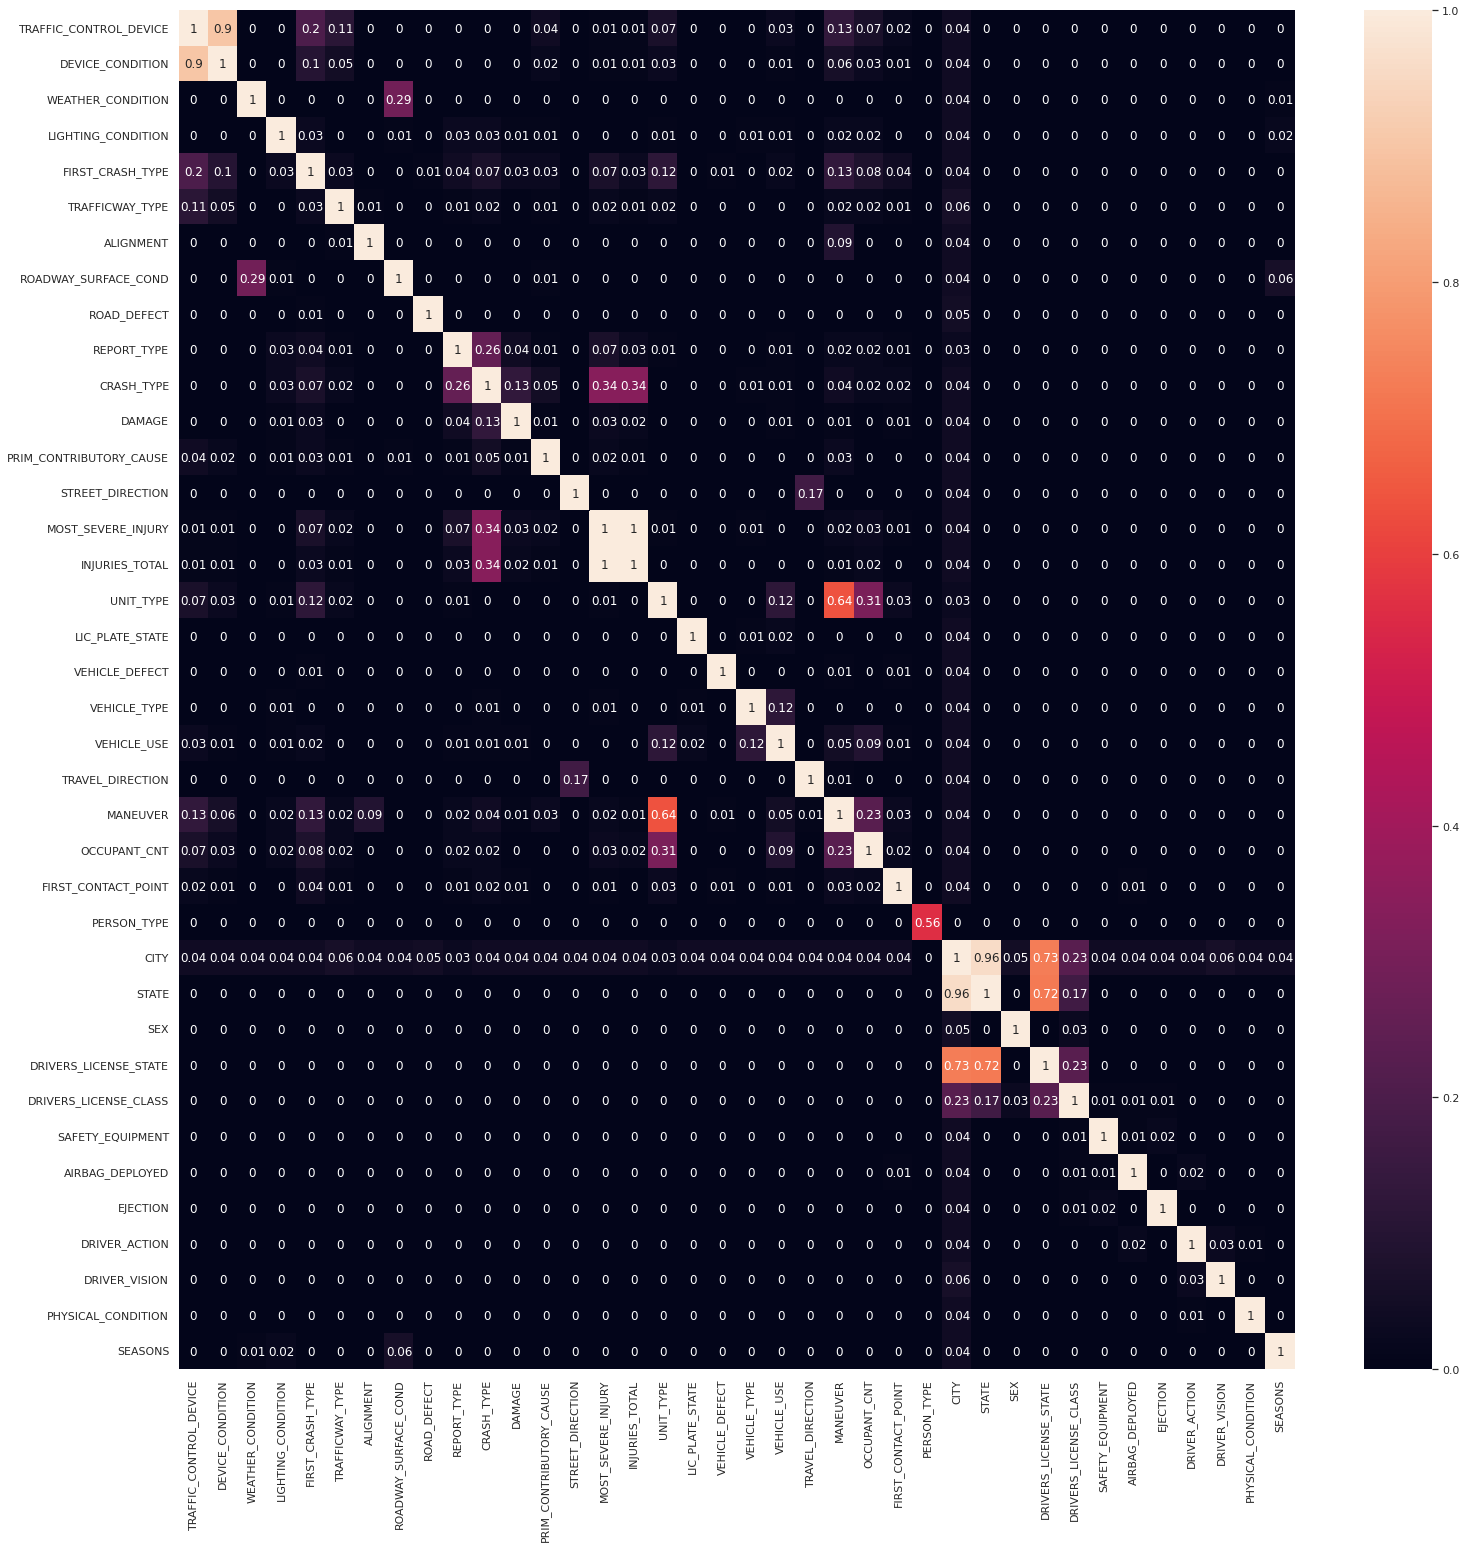

<Figure size 1800x1800 with 0 Axes>

In [319]:
import matplotlib.pyplot as plt

# generating 2-D 10x10 matrix of random numbers
# from 1 to 100
data = np.random.randint(low=1,high=100,size=(15,15))
  
# setting the parameter values
annot = True

sns.set(rc={'figure.figsize':(25,25)})
# plotting the heatmap
hm = sns.heatmap(data=df_corr_cat,annot=annot)

# displaying the plotted heatmap
plt.show()

plt.savefig('heatmap.png', bbox_inches='tight')

- Drivers_License_Class and Drivers_License City is highy Corelated to CITY and STATE. So we think we can drop one set.
- Manover is correlated with UNIT TYPE
- TRAFFIC CONTROL DEVICE CORRELATED WITH DEVICE CONDITION
- Road Condition is correlated to Weather Condition 


In [320]:

df_crash_final.drop(['FIRST_CONTACT_POINT'], axis=1, inplace=True)
df_crash_final.drop(['MANEUVER'], axis=1, inplace=True)
df_crash_final.drop(['WEATHER_CONDITION'], axis=1, inplace=True)
df_crash_final.drop(['DRIVERS_LICENSE_STATE'], axis=1, inplace=True)
df_crash_final.drop(['DEVICE_CONDITION'], axis=1, inplace=True)
df_crash_final.drop(['INJURIES_TOTAL'], axis=1, inplace=True)
df_crash_final.drop(['CRASH_HOUR'], axis=1, inplace=True)
df_crash_final.drop(['UNIT_TYPE'], axis=1, inplace=True)
df_crash_final.drop(['CRASH_TYPE'], axis=1, inplace=True)
df_crash_final.drop(['REPORT_TYPE'], axis=1, inplace=True)
df_crash_final.drop(['OCCUPANT_CNT'], axis=1, inplace=True)
df_crash_final.drop(['PERSON_TYPE'], axis=1, inplace=True)
df_crash_final.drop(['PHYSICAL_CONDITION'], axis=1, inplace=True)
df_crash_final.drop(['TRAVEL_DIRECTION'], axis=1, inplace=True)
df_crash_final.drop(['DRIVER_ACTION'], axis=1, inplace=True)
df_crash_final.drop(['DRIVERS_LICENSE_CLASS'], axis=1, inplace=True)
df_crash_final.drop(['CITY'], axis=1, inplace=True)

Based on the Cramers V test we were able to identify the highly correlated values. We have deleted the corelated values. This would be good for our analysis.

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

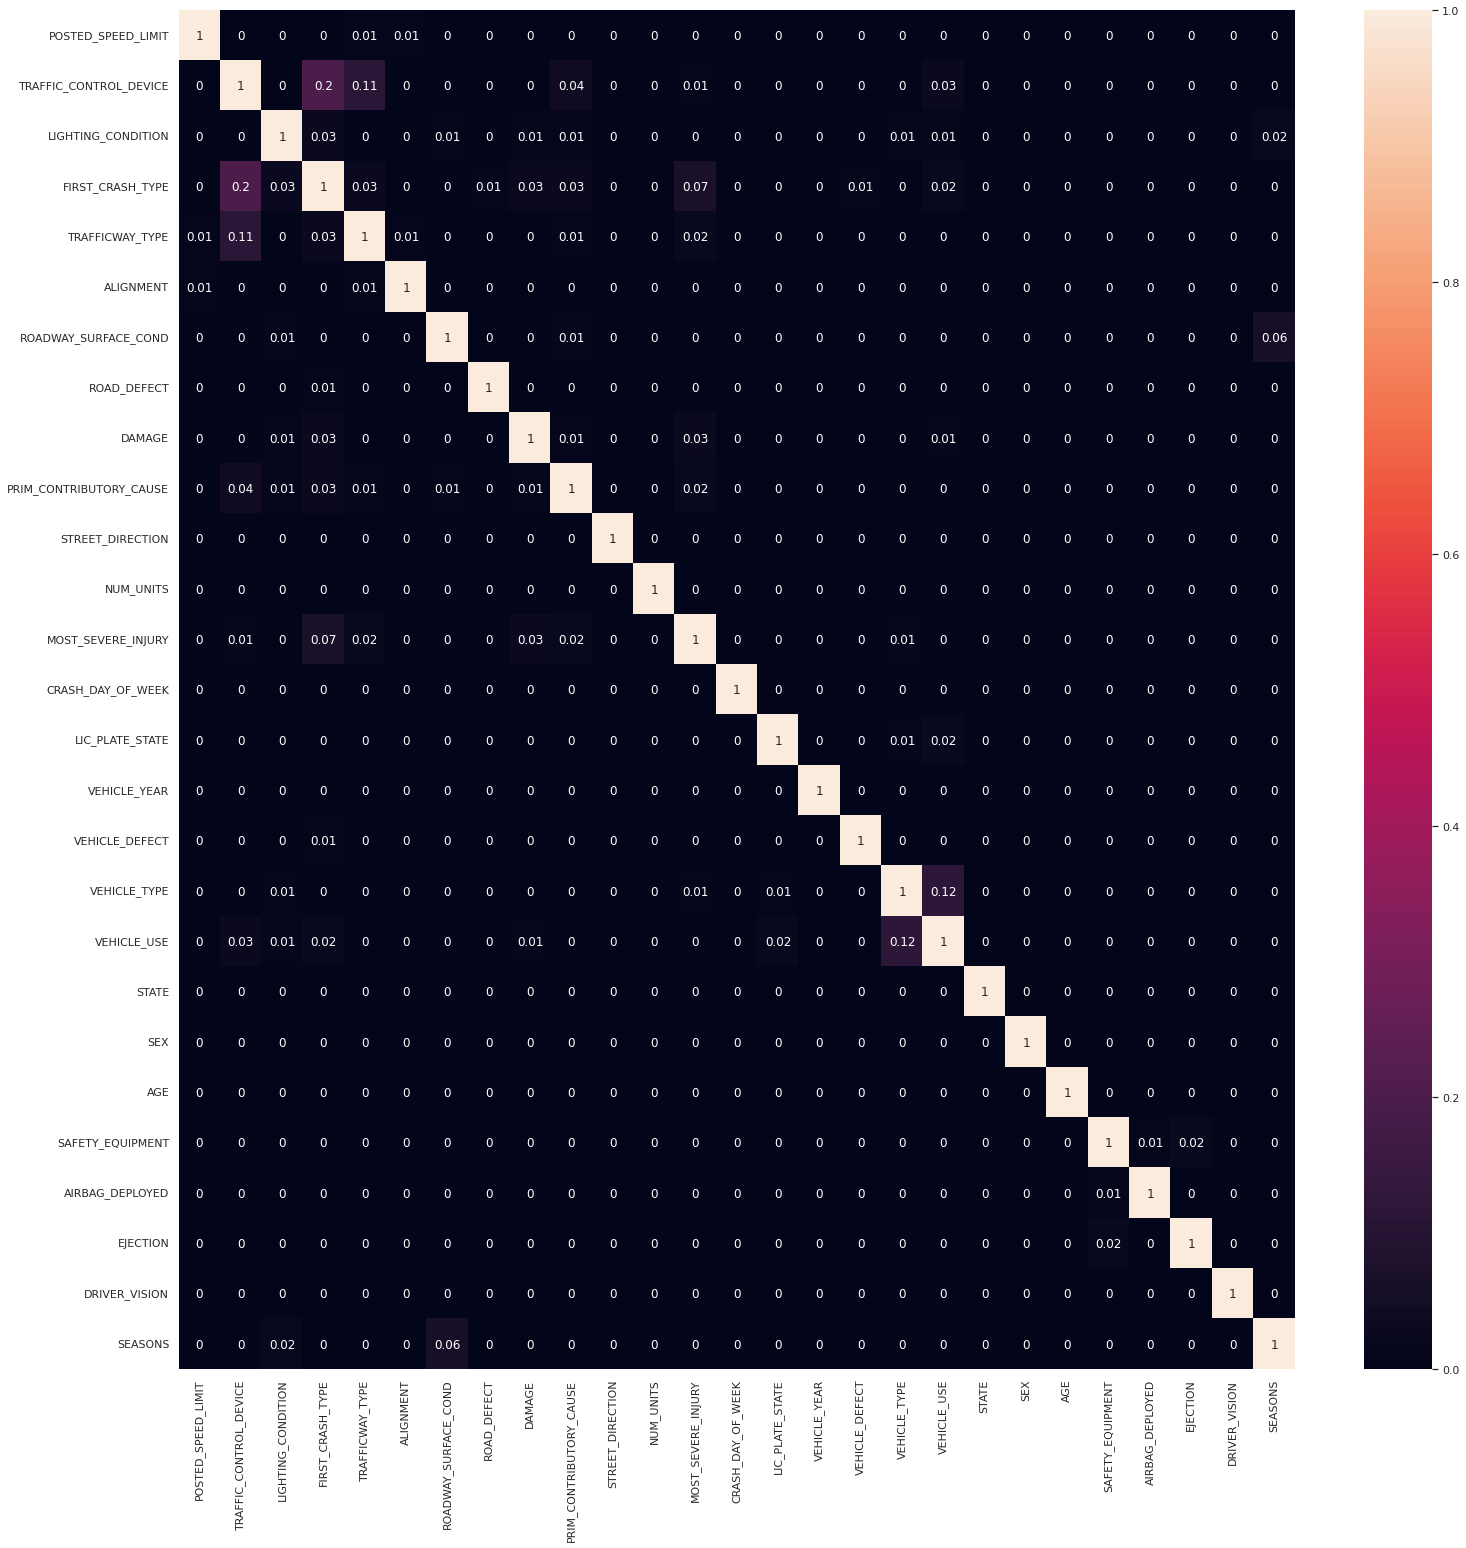

<Figure size 1800x1800 with 0 Axes>

In [321]:
column_datatypes = df_crash_final.dtypes


categorical_columns = list(column_datatypes[column_datatypes=="object"].index.values)
continuous_columns = list(column_datatypes[column_datatypes=="float64"].index.values)

df_eda=df_crash_final.copy(deep=True)

for cf1 in categorical_columns:
    le = LabelEncoder()
    le.fit(df_eda[cf1].unique())
    df_eda[cf1] = le.transform(df_eda[cf1])

from scipy.stats import chi2_contingency
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))
rows= []

for var1 in categorical_columns:
  col = []
  for var2 in categorical_columns :
    cramers =cramers_V(df_eda[var1], df_eda[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df_corr_cat = pd.DataFrame(cramers_results, columns = categorical_columns, index =categorical_columns)

import matplotlib.pyplot as plt

# generating 2-D 10x10 matrix of random numbers
# from 1 to 100
data = np.random.randint(low=1,high=100,size=(15,15))
  
# setting the parameter values
annot = True

sns.set(rc={'figure.figsize':(25,25)})
# plotting the heatmap
hm = sns.heatmap(data=df_corr_cat,annot=annot)

# displaying the plotted heatmap
plt.show()

plt.savefig('heatmap.png', bbox_inches='tight')

Post deleting the highly correlated categorical variables we can see that the dataset is cleaned and there are no correlated values now.
We have reduced the dataset from 150 Features to 34 Features.

- Labels have been reduced on all the categories for better clustering and analysis.

# EXPLORATORY DATA ANALYSIS

In [322]:
print(" There are ",df_crash_final.shape[0] , " rows and ",df_crash_final.shape[1] , " columns in the merged and cleaned dataset ")

 There are  28132  rows and  33  columns in the merged and cleaned dataset 


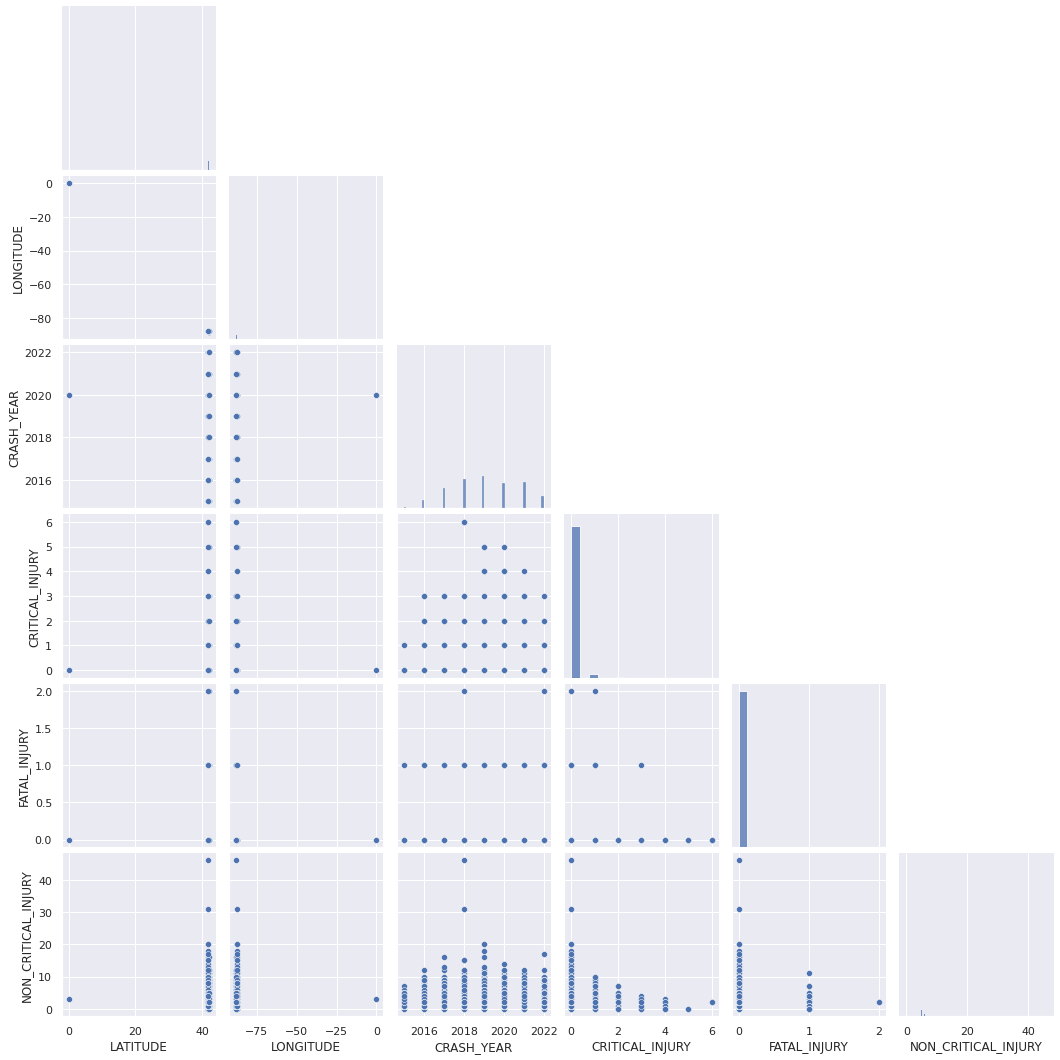

In [323]:
# Multivariate Analysis using Pairplot

pairplot = sns.pairplot(df_crash_final, corner=True)
plt.show(pairplot)

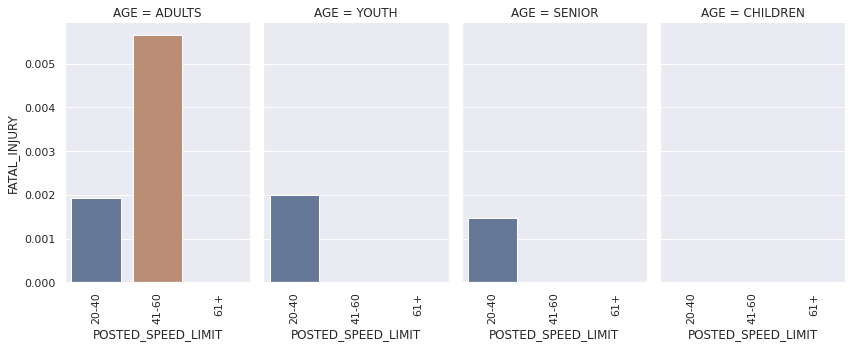

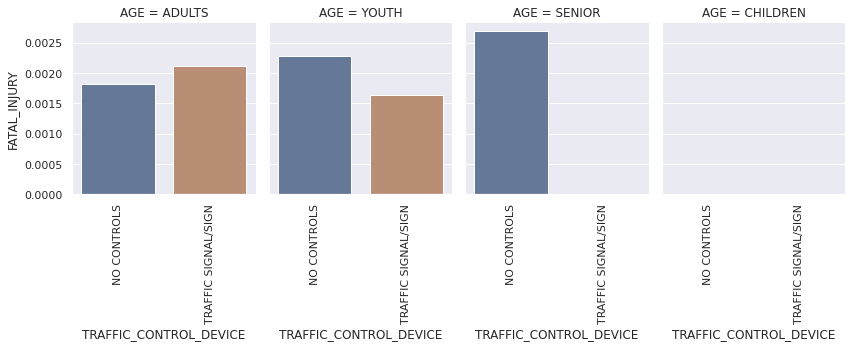

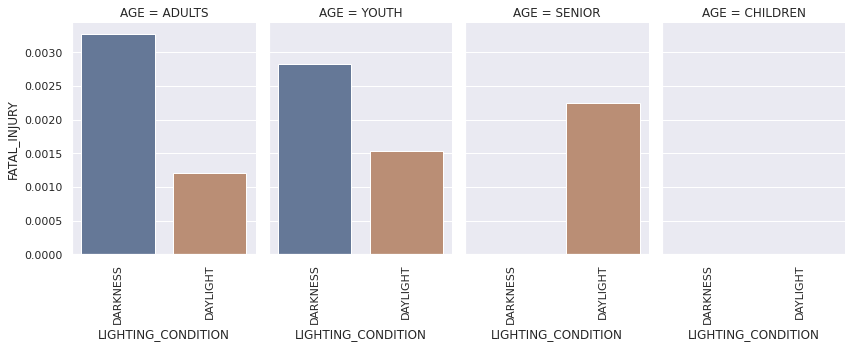

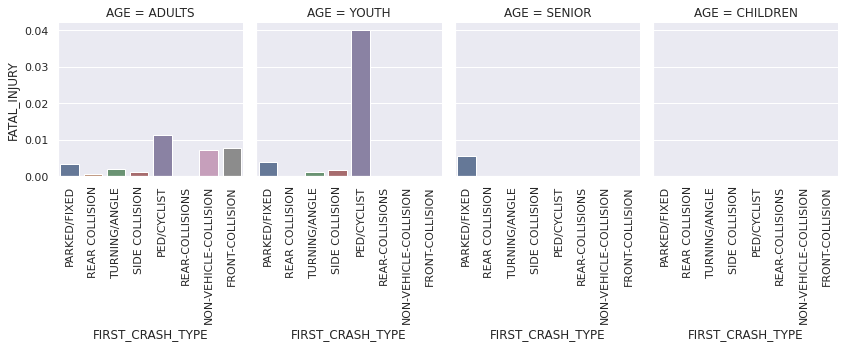

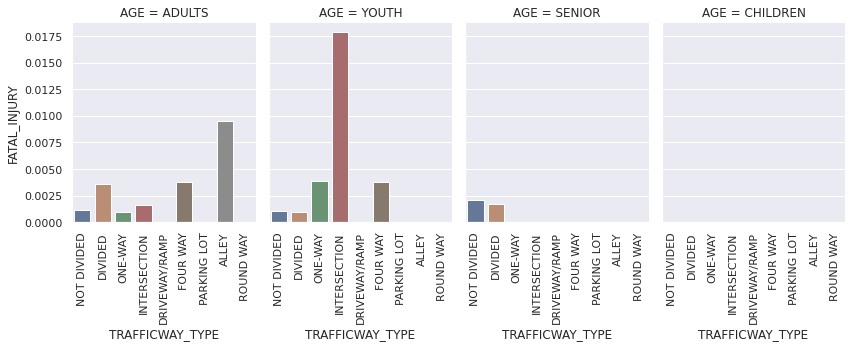

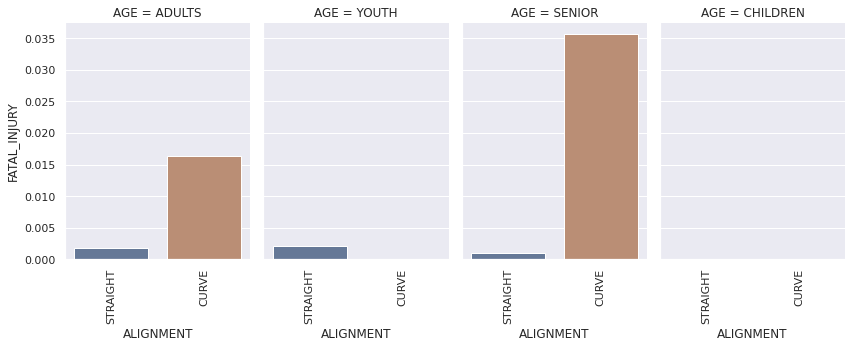

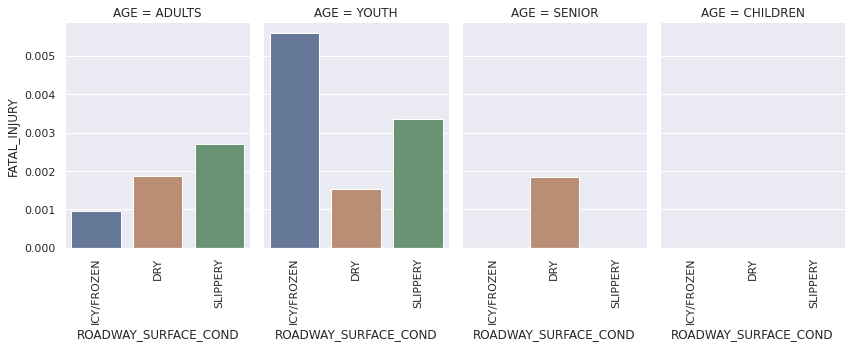

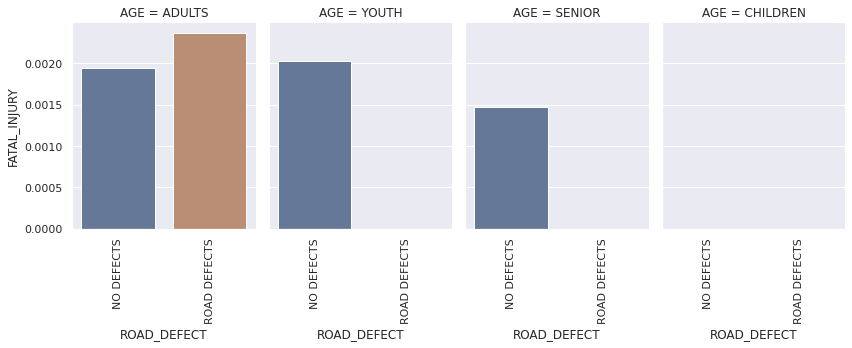

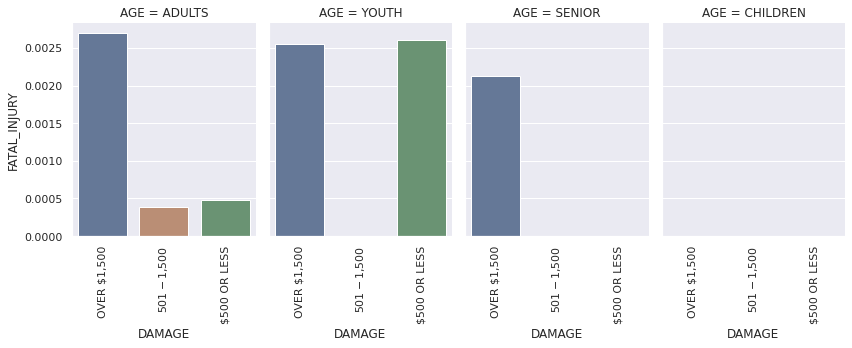

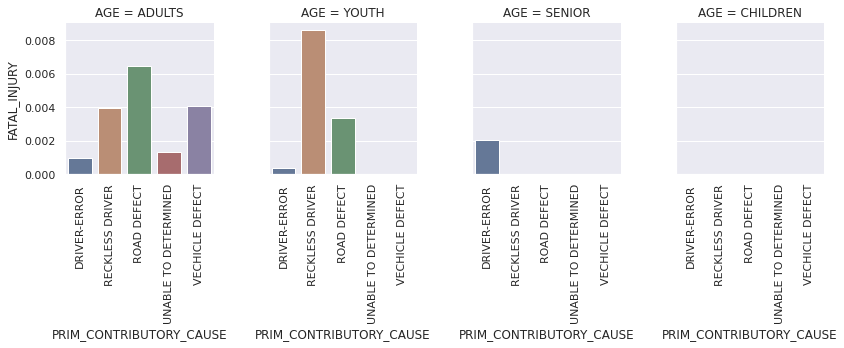

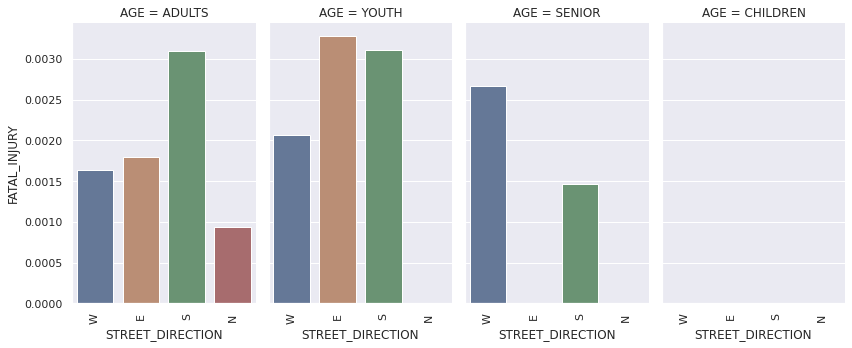

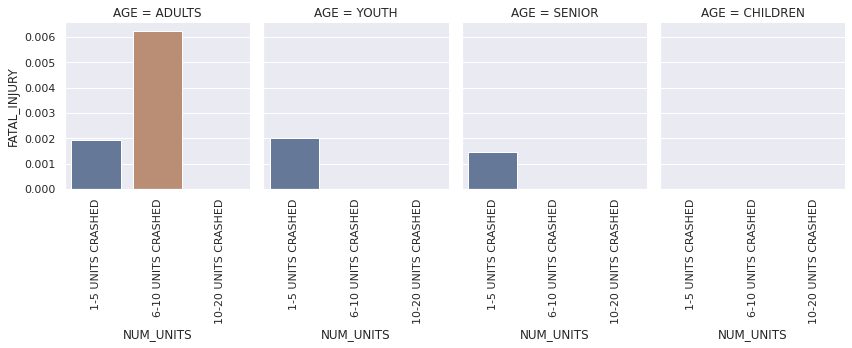

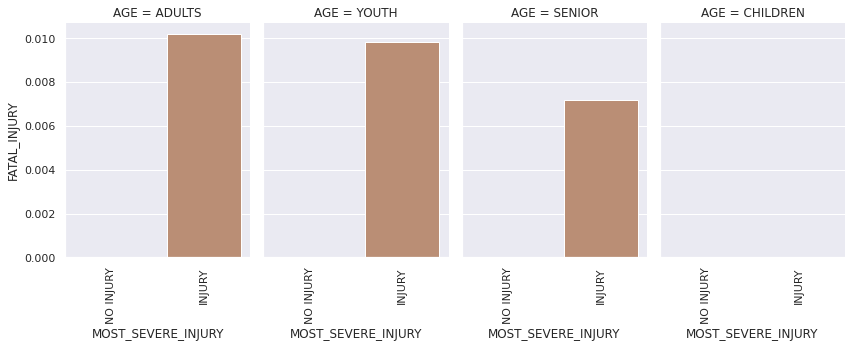

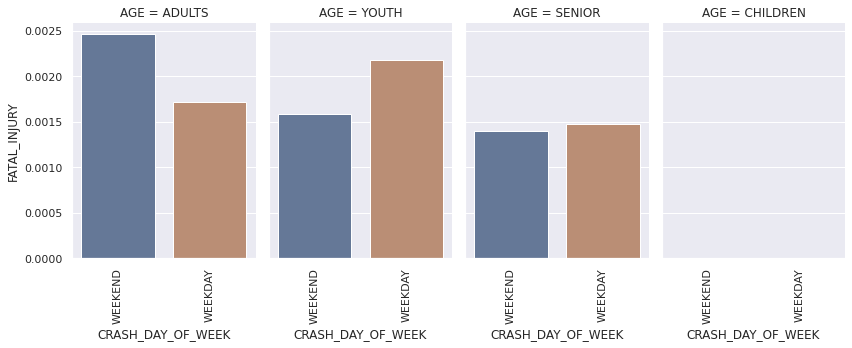

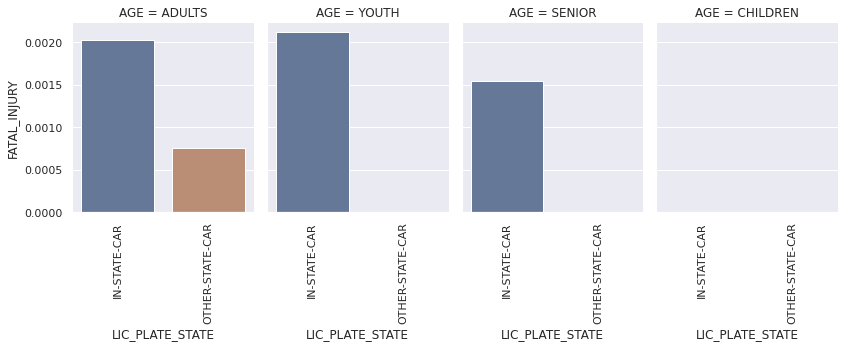

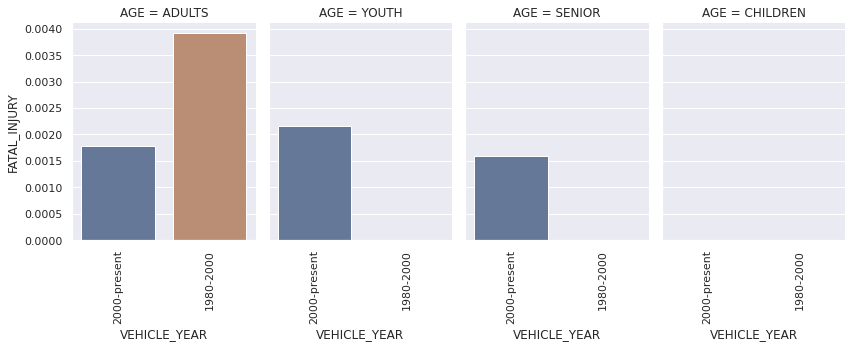

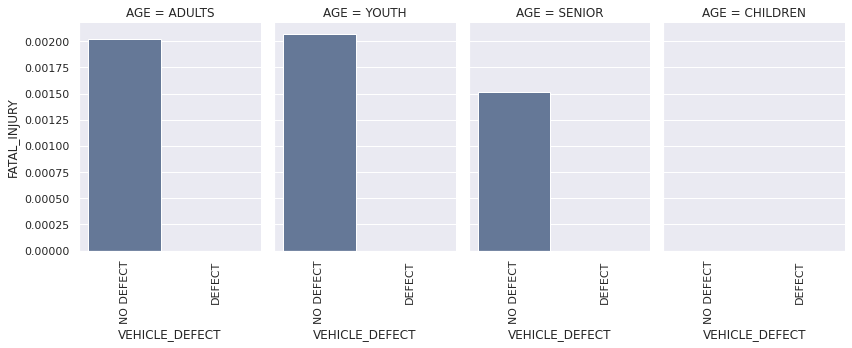

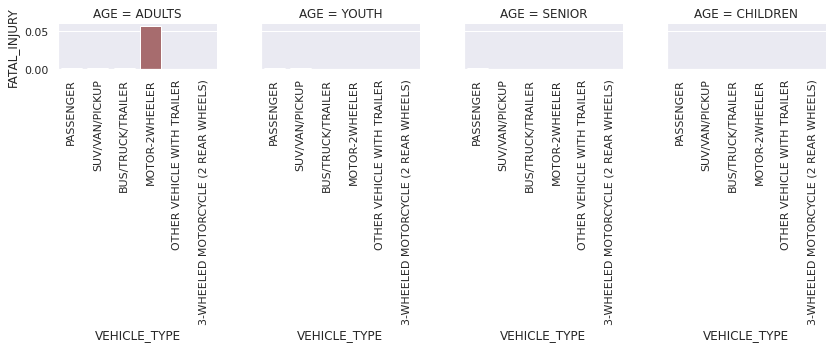

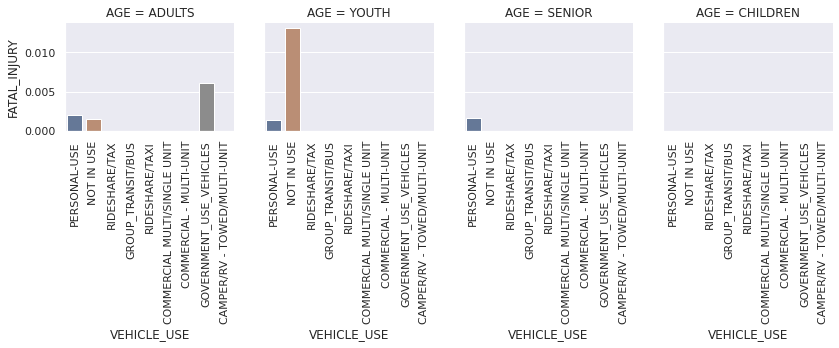

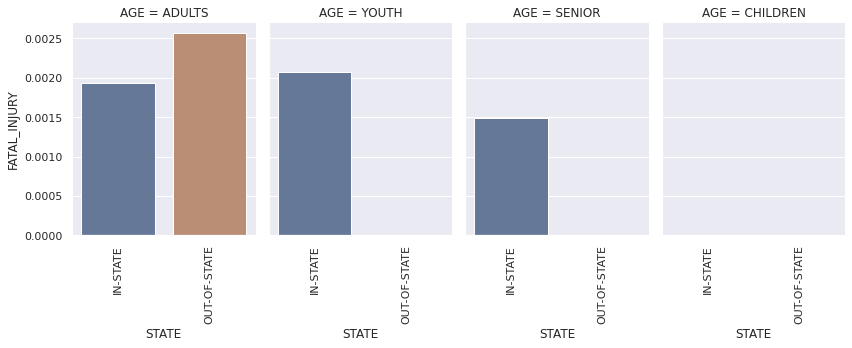

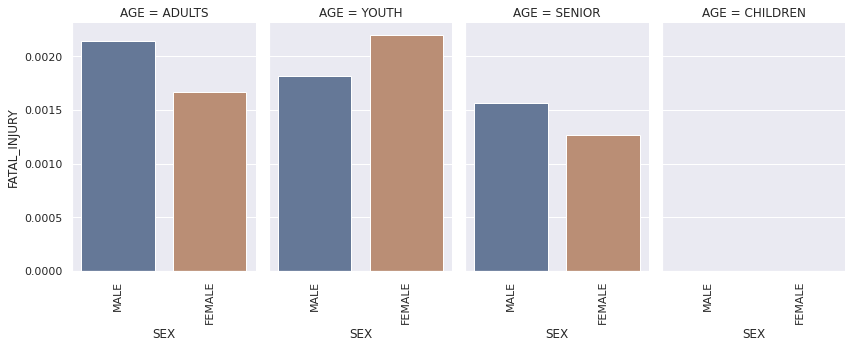

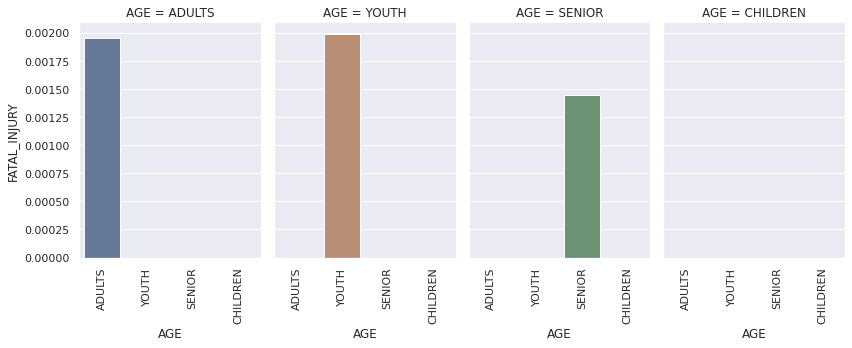

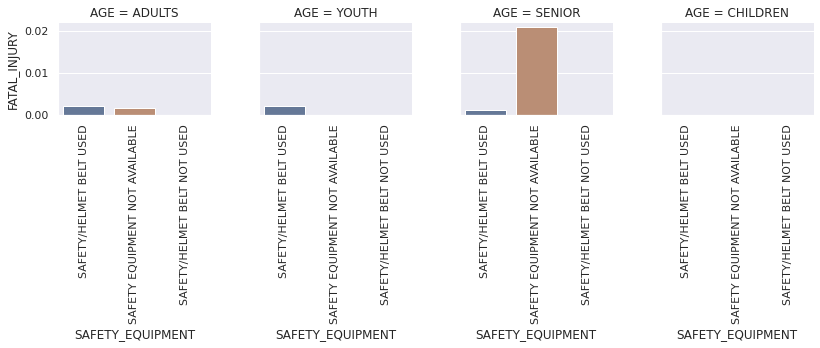

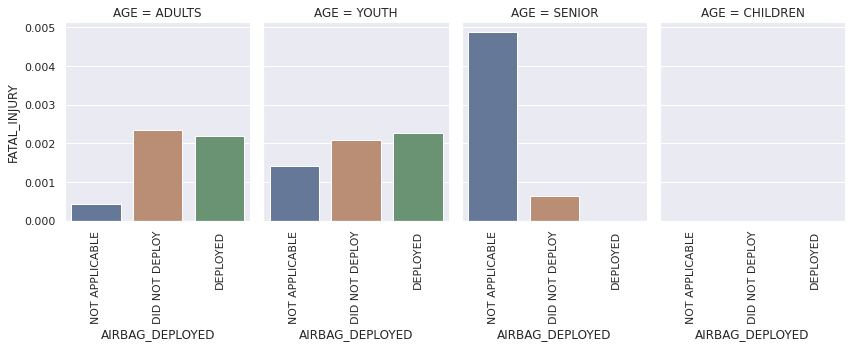

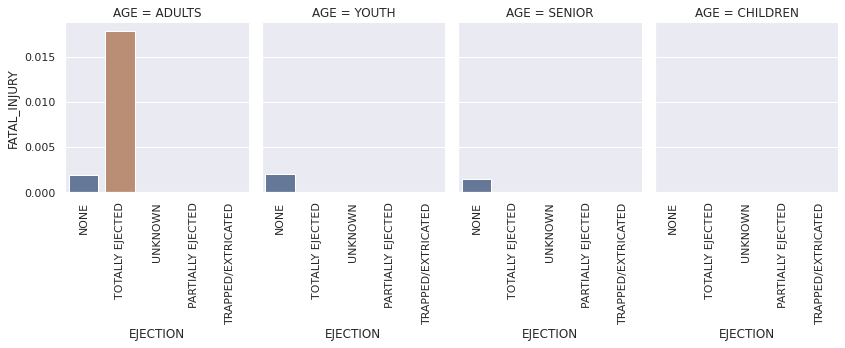

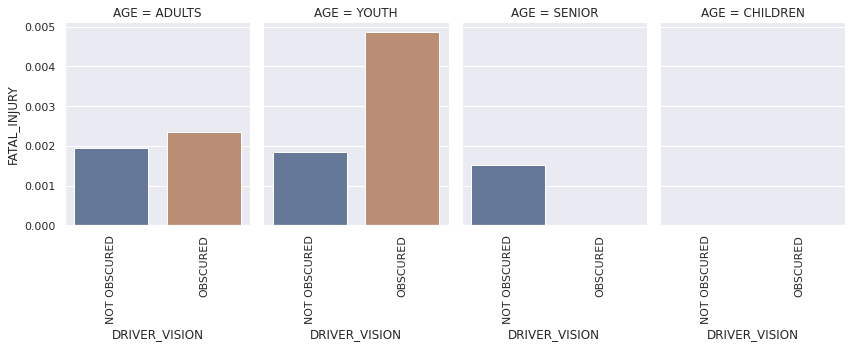

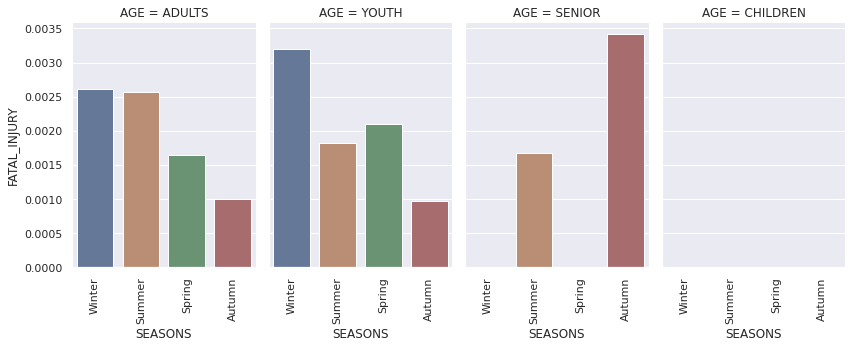

<Figure size 1800x1800 with 0 Axes>

In [324]:
from typing import TYPE_CHECKING
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
column_datatypes = df_crash_final.dtypes
categorical_columns = list(column_datatypes[column_datatypes=="object"].index.values)
continuous_columns = list(column_datatypes[column_datatypes=="float64"].index.values)
for col in categorical_columns:
  g = sns.catplot(x=col, y="FATAL_INJURY",col="AGE",data=df_crash_final, saturation=.5,kind="bar", ci=None, aspect=.6)
  for ax in g.axes.flat:
  #ax.yaxis.set_major_formatter(PercentFormatter(1))
    _=ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

 
  # Ensure good spacing  
  g.fig.tight_layout()


plt.tight_layout()

plt.show()
plt.tight_layout()




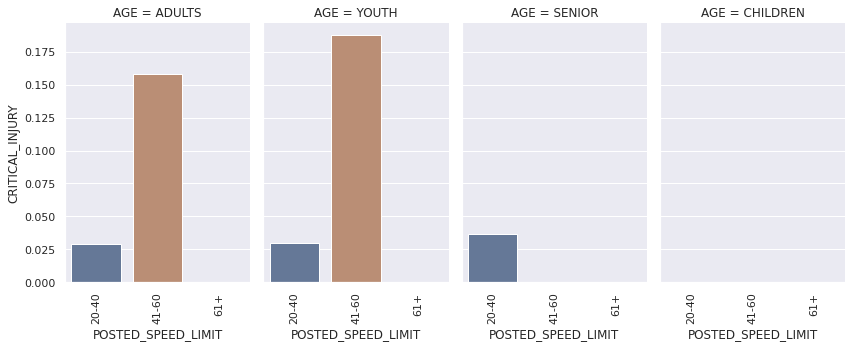

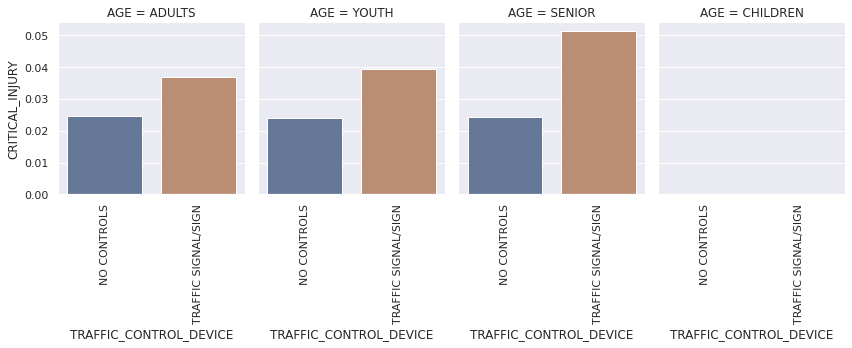

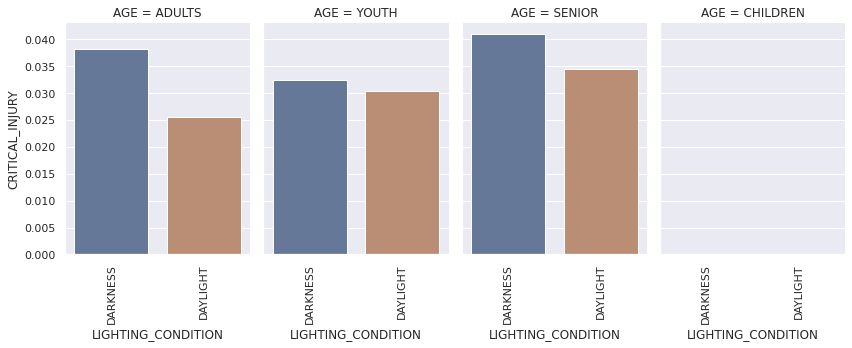

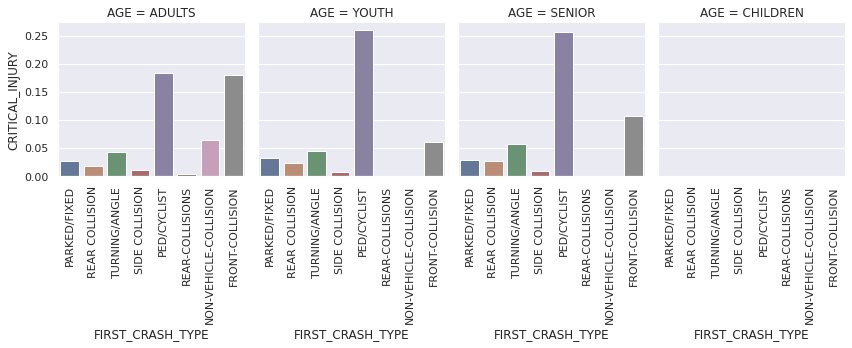

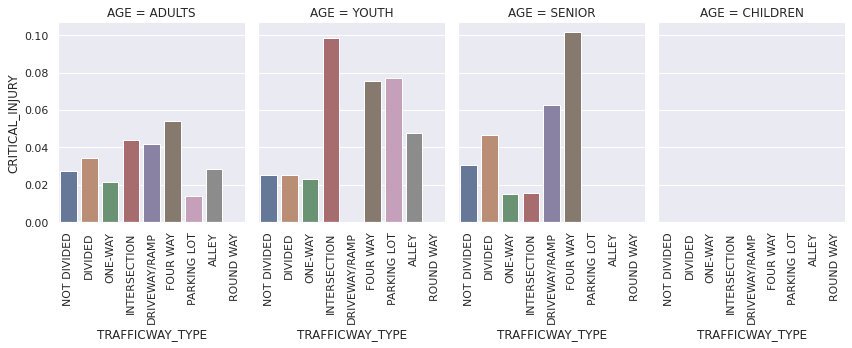

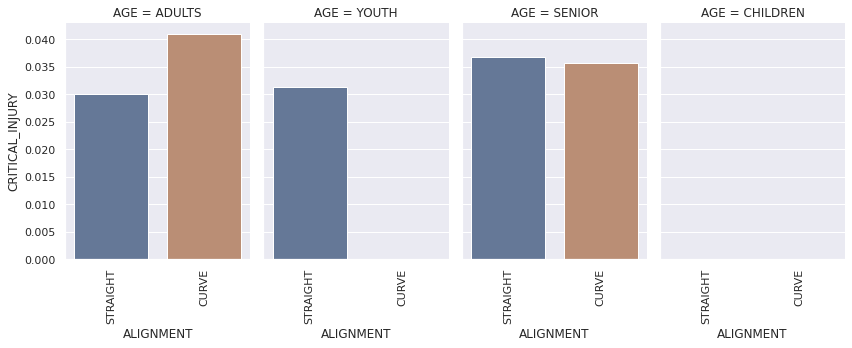

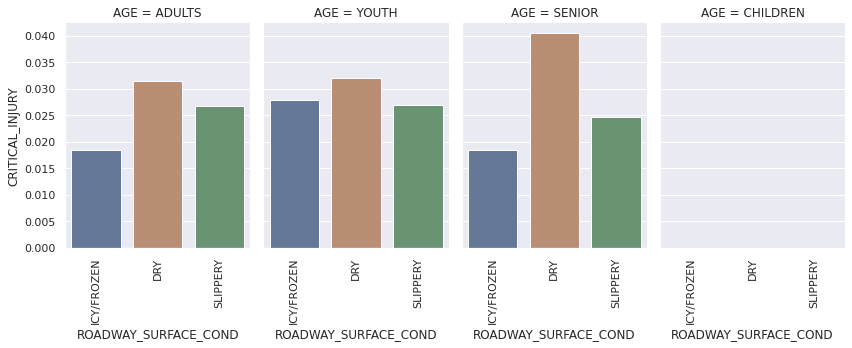

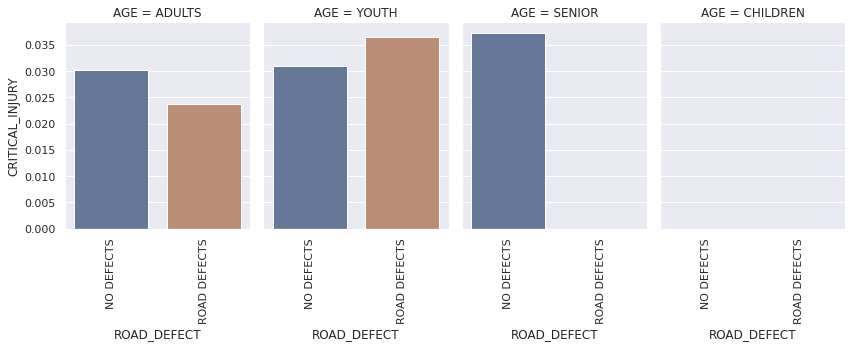

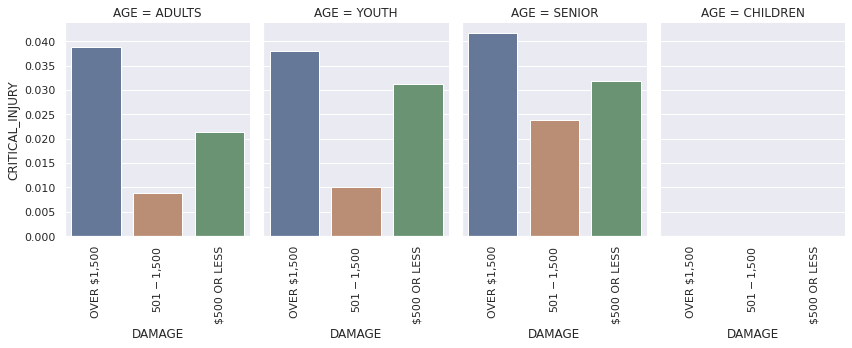

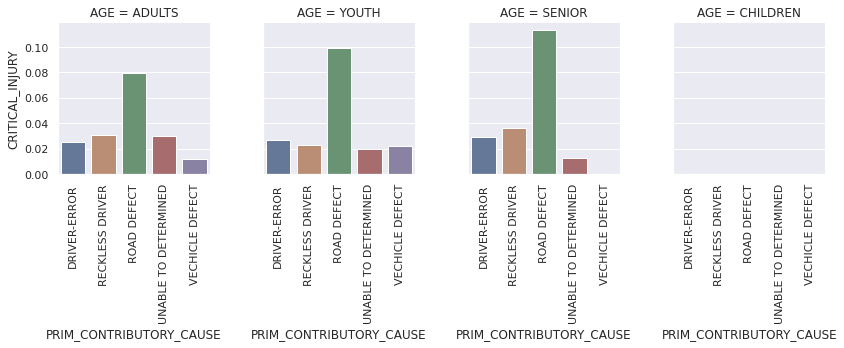

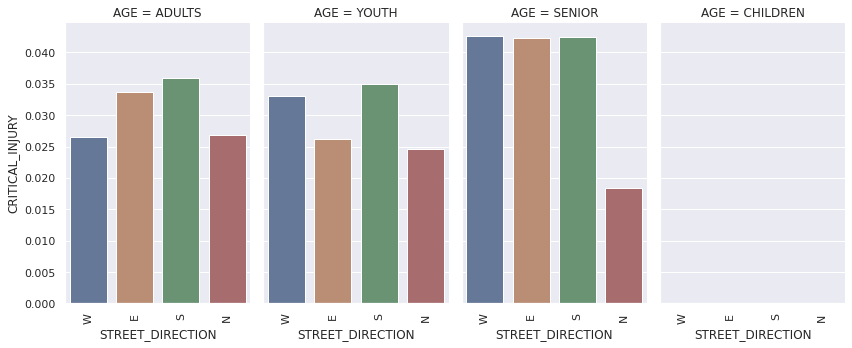

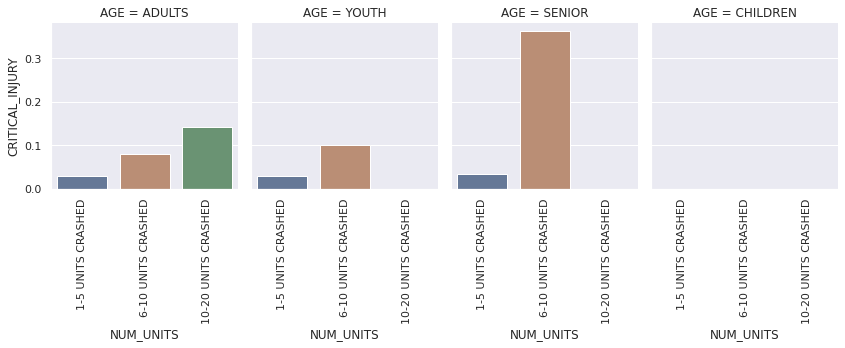

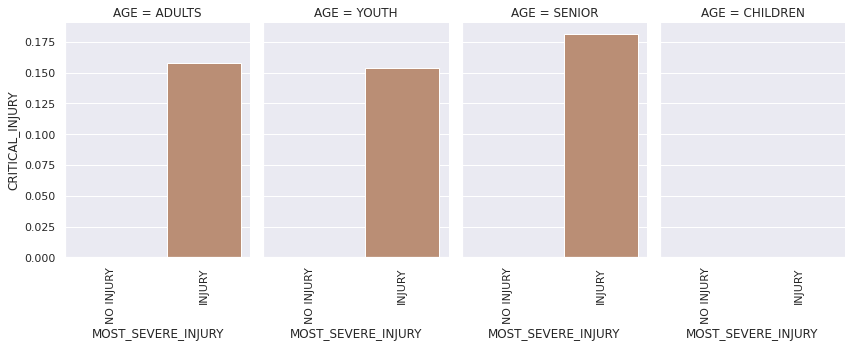

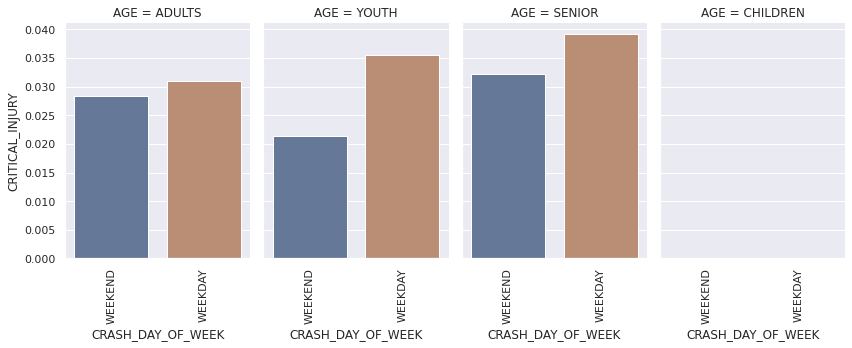

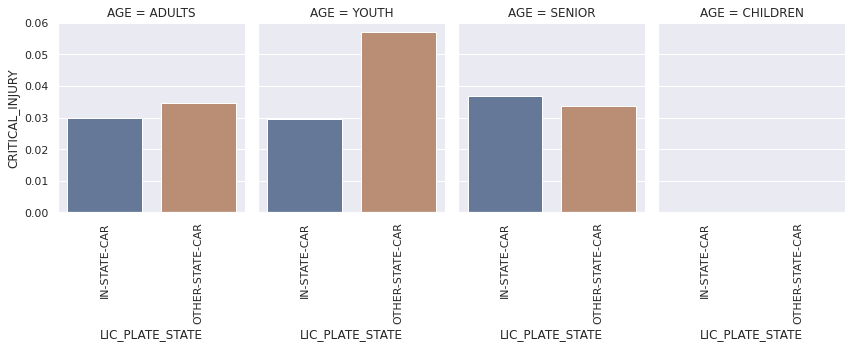

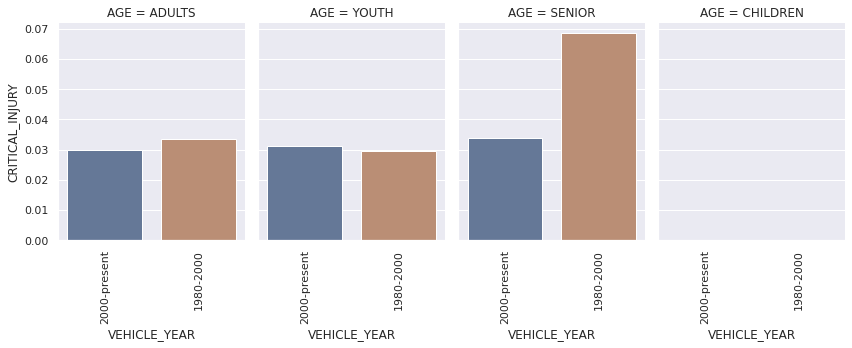

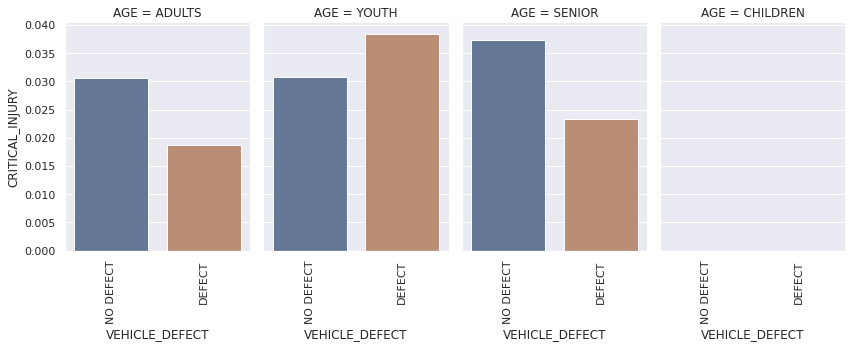

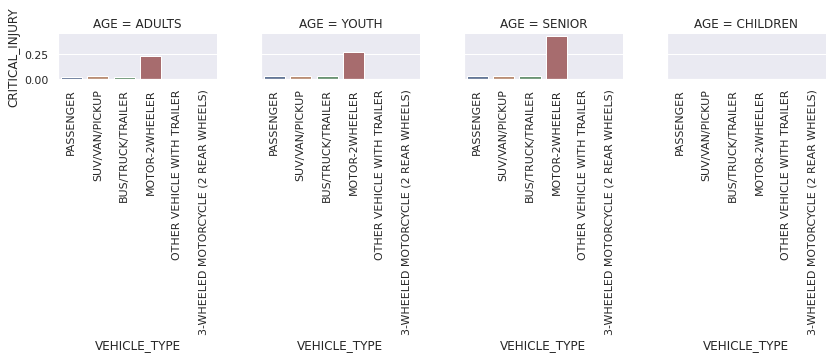

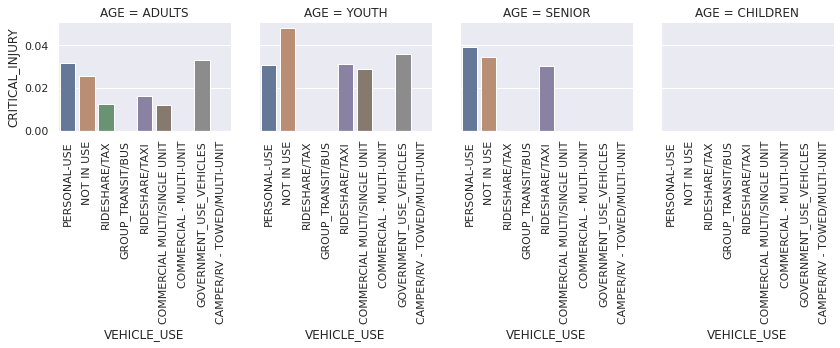

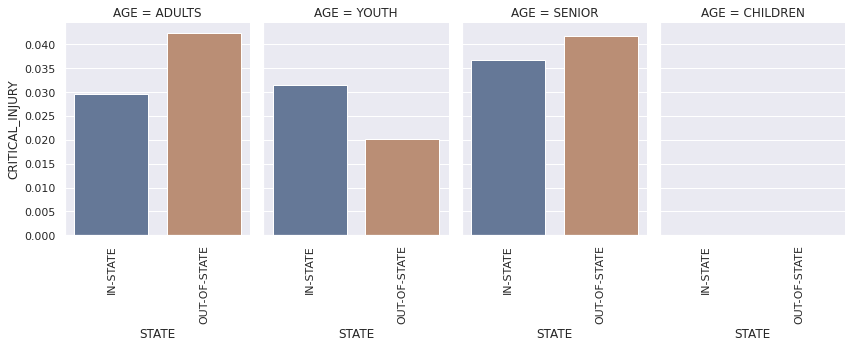

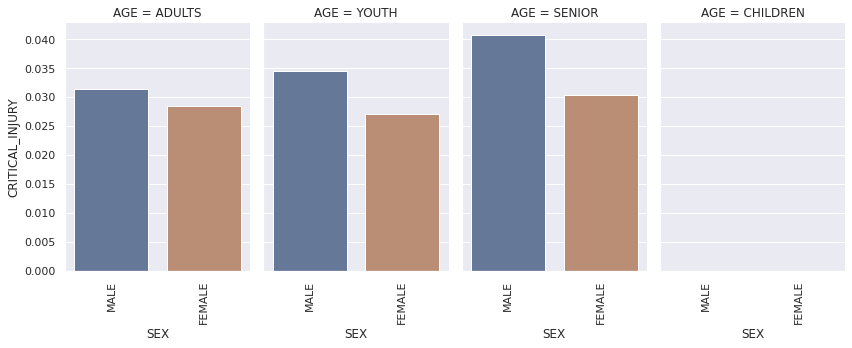

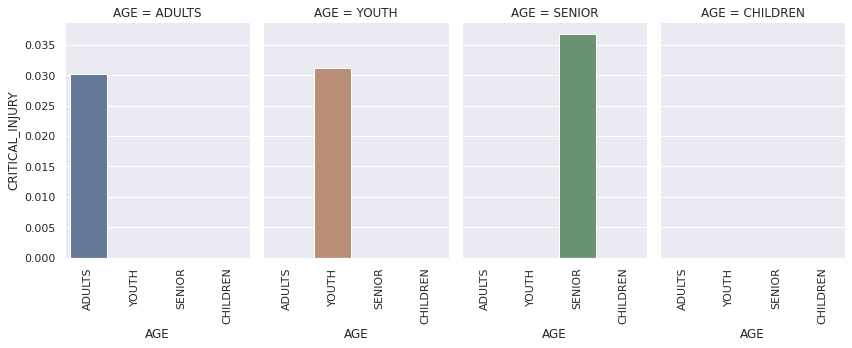

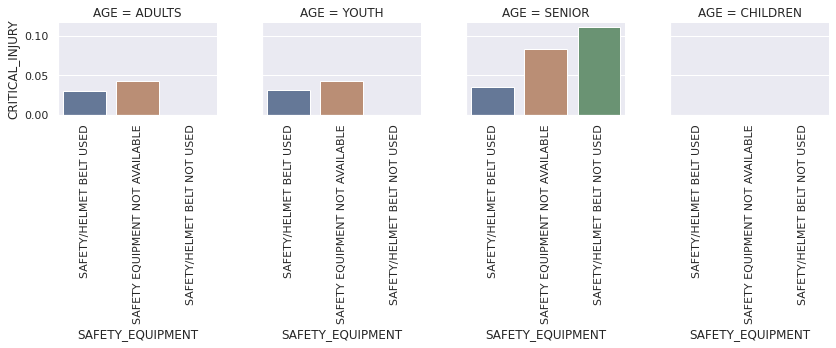

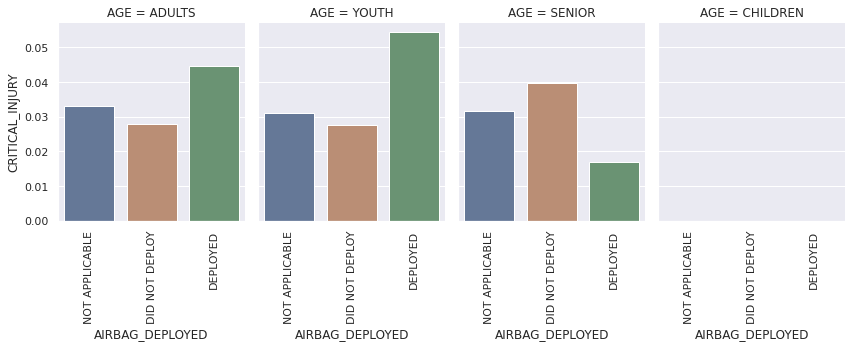

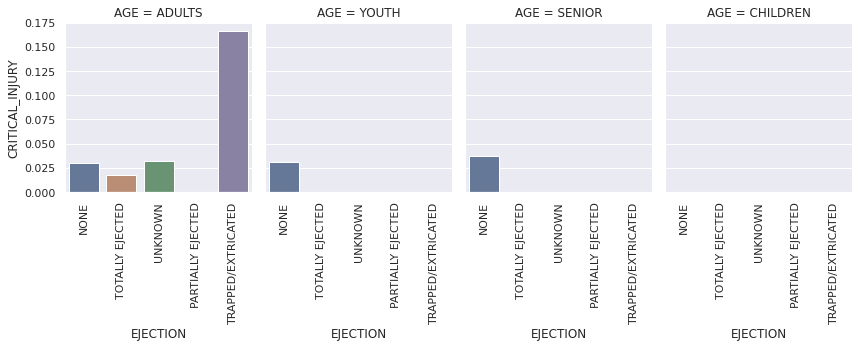

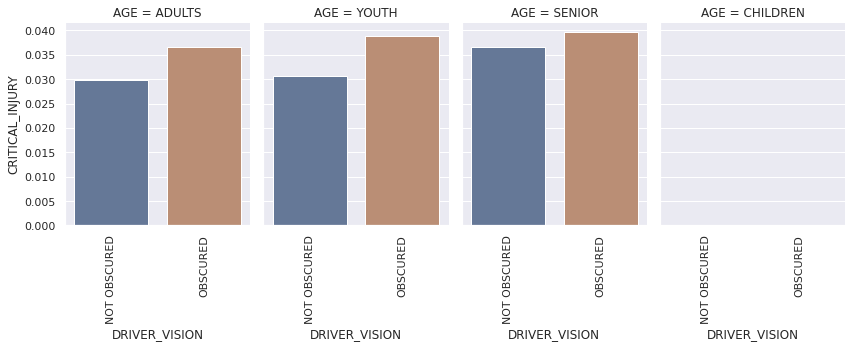

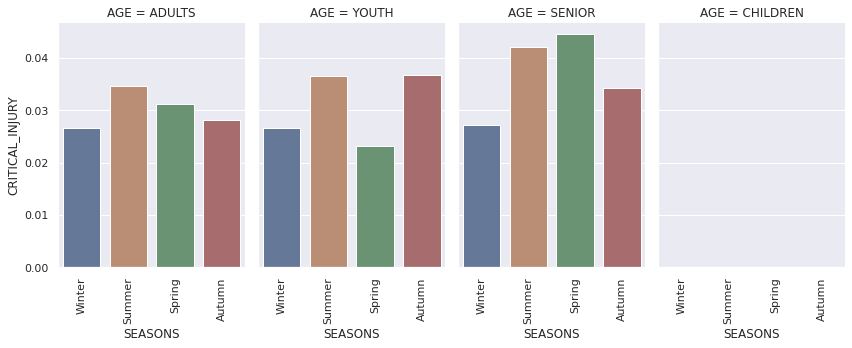

<Figure size 1800x1800 with 0 Axes>

In [325]:
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
column_datatypes = df_crash_final.dtypes
categorical_columns = list(column_datatypes[column_datatypes=="object"].index.values)
continuous_columns = list(column_datatypes[column_datatypes=="float64"].index.values)
for col in categorical_columns:
  g = sns.catplot(x=col, y="CRITICAL_INJURY",col="AGE",data=df_crash_final, saturation=.5,kind="bar", ci=None, aspect=.6)
  for ax in g.axes.flat:
  #ax.yaxis.set_major_formatter(PercentFormatter(1))
    _=ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

 
  # Ensure good spacing  
  g.fig.tight_layout()


plt.tight_layout()

plt.show()
plt.tight_layout()



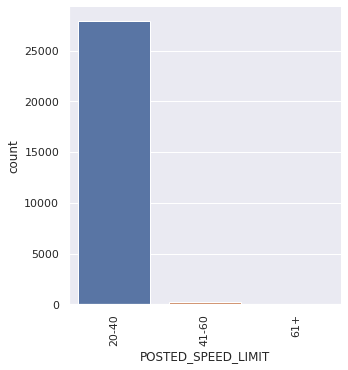

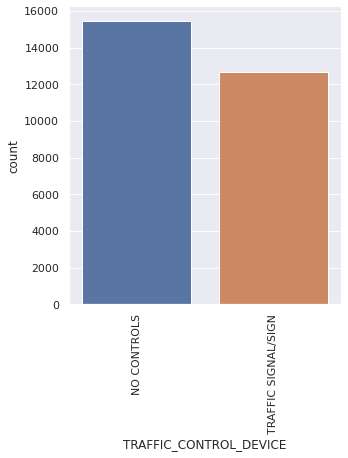

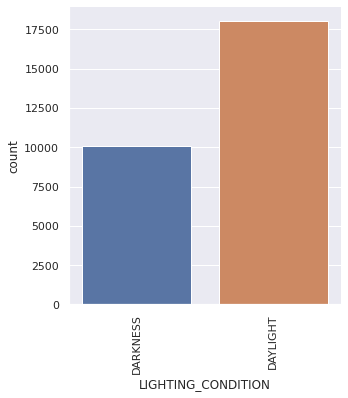

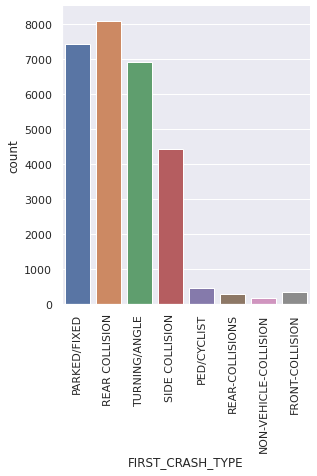

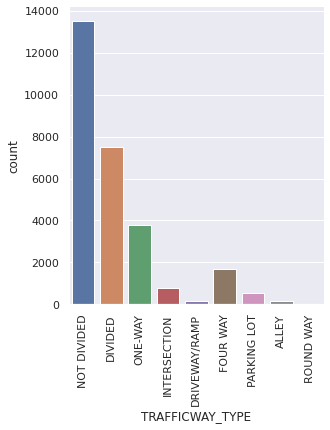

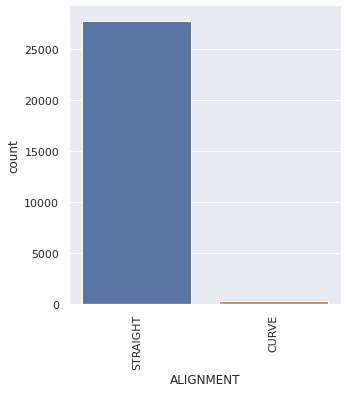

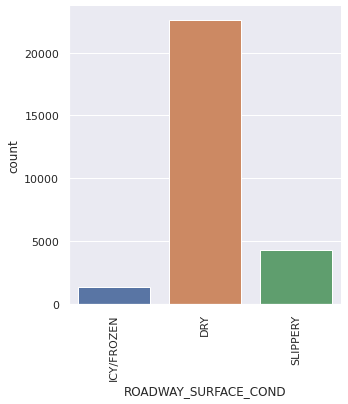

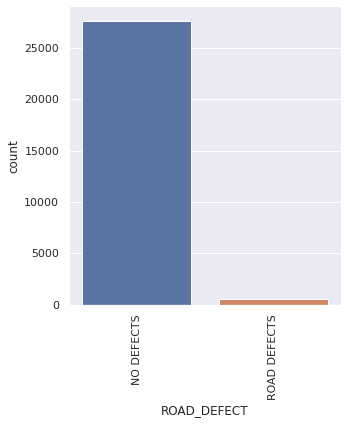

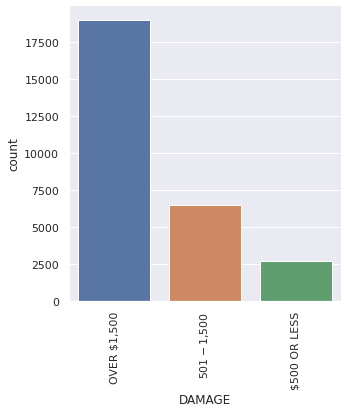

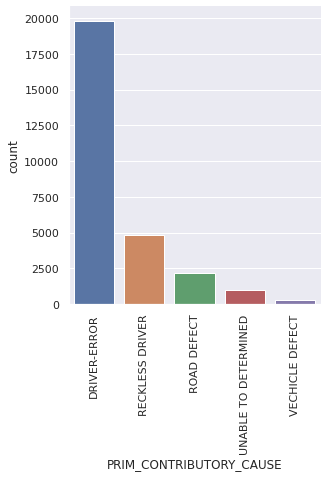

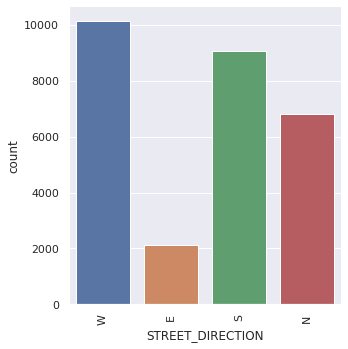

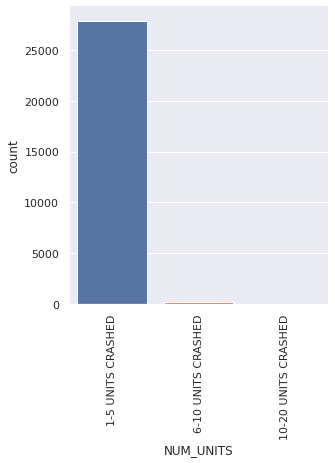

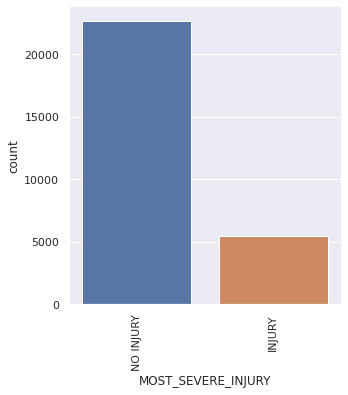

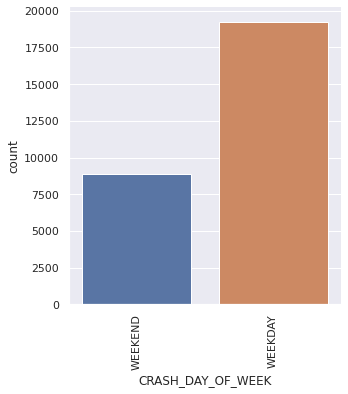

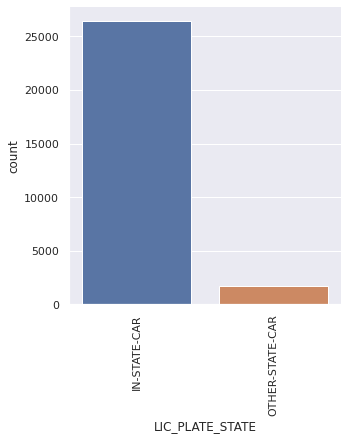

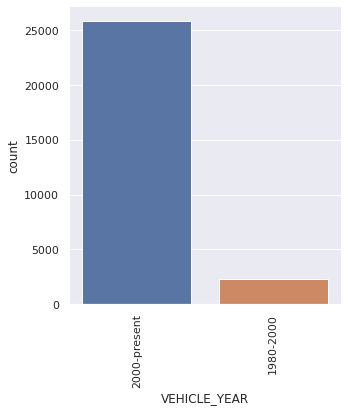

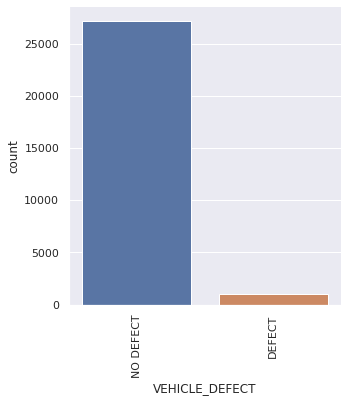

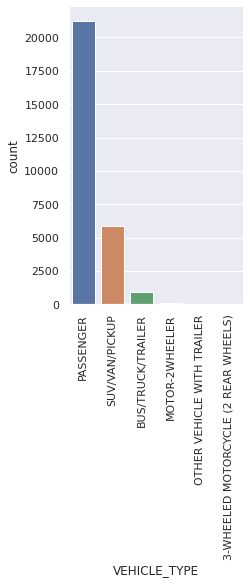

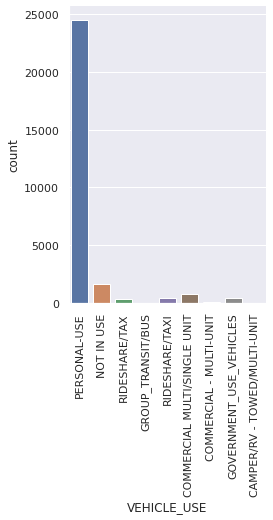

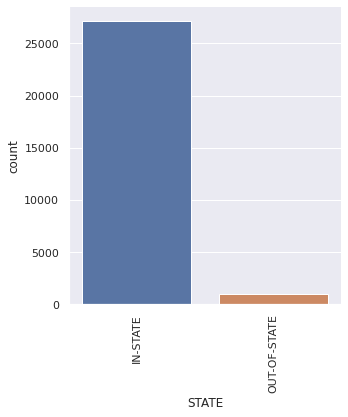

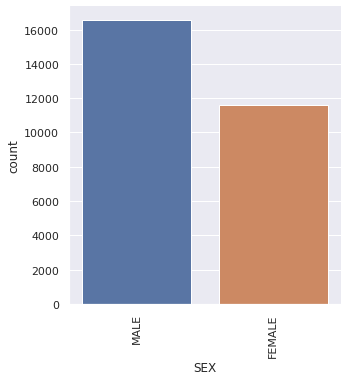

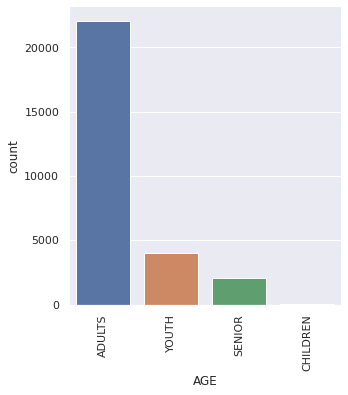

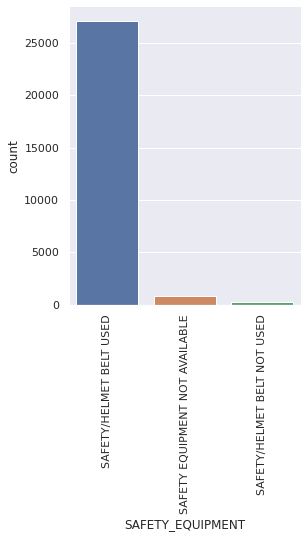

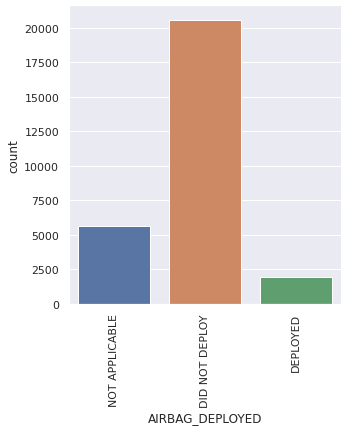

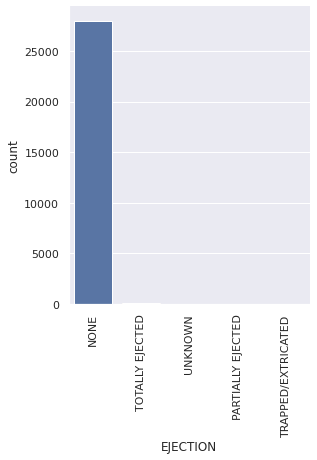

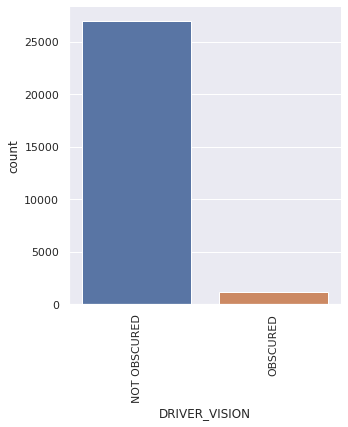

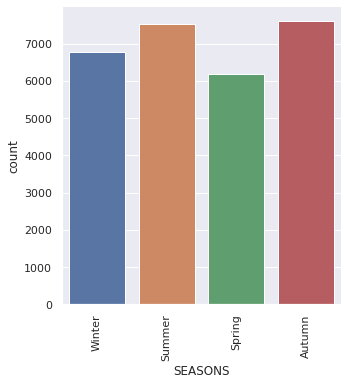

In [326]:
for col in categorical_columns:
  g=sns.factorplot(col, data=df_crash_final, kind="count")
  for ax in g.axes.flat:
    _=ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

**Interesting Observation**
- Most of the Fatal Injuries happen to adults between 41-60 years
- Mostly Accidents involving  Youth and  Seniors occur when there is no Traffic Control device.
-Adults and Youth meet with Fatal injury accident during the dark which is the night time. But for Senior Citizens its more during the day this could be due to other factors.
- Youth who in a FATAL Injury are mostly cyclist/Pedestrians

- Adults and youth meet with Fatal accidents when the road surface is ICY/FROZEN. Now Senor citizens meet with Fatal injuries when the road is dry again other factors in place.

- When Adults and Youth meet with Fatal injuries the damagge is mostly above 1500 dollars now this could be because of the price of the car.
- Primary Contributory factor for Fatal injuries in youth is drivers recklessness behavior of the driver. Primary contributory factor of the Adults is Road Defect. Meanwhile seniors meet with accidents due to Driver Error.

- Adults meet with accidents when the street direction is South .Generally Roads Facing South , East, West have higher number of Accidents which lead to Fatal injuries this could be because of the Sun Direction.
-Fatal injuries occur in when there are more number of units involved in the accident.
-Common Pattern observed in the dataset is that  Fatal injuries due to accidents occur in Adults, Youth and Senior in th early morning. This could be because nightclubs and bars close in the morning.
- In Adults most accidents happen in the weekday meanwhile youth  most of the accidents happen in the weekend because of party and weekend being a holiday in general.
- Adults driving Driverless vehicles met with Accidents more now this coulf be because they are unaware how to operate.
- Most accidents takes place with instate cars.
- Mostly old Vintage vehicles between 1980-2000 are used by Adults and also most Fatal injuries due to accident occur in these old vehicles
- Fatal injuries mostly occur in 2 wheeler motor vehicles.

- Fatal Accidents occur more to adult male and Senior Male , however more young Females meet with Fatal accidents
- Fatal injuries due to accidents occur to senior citizens driving vehicles without safety Equipments
- Adults and Youth meet with Fatal accidents during the  Winter, Summer and Spring. This could be due extreme weather conditions in Illinois/Chicago


Critical Injuries are injuries that are not severe.

- Critical injuries occur mostly when the Lighting condtion is Dark.

- Mostly Critical injuries occur to Pedestrians and Cyclists.
- Most of the Critical injuries occur in youth mostly in intersections and in Adults and Seniors it occurs in FOURWAY.
- Road surface condition does not impact Non critical accidents significantly.
- Youth meet with most of the accidents when there are road defects,

- Main contributor of the Critical injury in Road Defect in both Adults and Youth,



# CLUSTERING MODEL

In [327]:
column_datatypes = df_crash_final.dtypes
categorical_columns = list(column_datatypes[column_datatypes=="object"].index.values)
continuous_columns = list(column_datatypes[column_datatypes=="float64"].index.values)

In [328]:
from sklearn.preprocessing import StandardScaler
df_crash_final[df_crash_final[continuous_columns].columns] = StandardScaler().fit_transform(df_crash_final[continuous_columns])

In [329]:
for cf1 in categorical_columns:
    le = LabelEncoder()
    le.fit(df_crash_final[cf1].unique())
    df_crash_final[cf1] = le.transform(df_crash_final[cf1])

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

## PCA

In [330]:
#PCA CODE
from sklearn.decomposition import PCA
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(df_crash_final)

In [331]:
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))

print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))


Explained variation per principal component: [0.19277462 0.14069593]
Cumulative variance explained by 2 principal components: 33.35%


In [332]:
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=df_crash_final.columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)



       POSTED_SPEED_LIMIT  TRAFFIC_CONTROL_DEVICE  LIGHTING_CONDITION  \
PC_1            0.002060                0.085146            0.022284   
PC_2            0.004465                0.031784            0.022810   

      FIRST_CRASH_TYPE  TRAFFICWAY_TYPE  ALIGNMENT  ROADWAY_SURFACE_COND  \
PC_1          0.787809         0.576801   0.000549              0.001062   
PC_2          0.566443         0.808988   0.004249              0.015468   

      ROAD_DEFECT    DAMAGE  PRIM_CONTRIBUTORY_CAUSE  STREET_DIRECTION  \
PC_1     0.000355  0.012276                 0.017437          0.001696   
PC_2     0.003896  0.007303                 0.010402          0.004268   

      NUM_UNITS  MOST_SEVERE_INJURY  CRASH_DAY_OF_WEEK  LATITUDE  LONGITUDE  \
PC_1   0.005016            0.017499           0.000272  0.009105   0.009466   
PC_2   0.000211            0.007770           0.002476  0.013401   0.011916   

      LIC_PLATE_STATE  VEHICLE_YEAR  VEHICLE_DEFECT  VEHICLE_TYPE  \
PC_1         0.002012

In [333]:
print("\n*************** Most important features *************************")
print('As per PC 1:\n', (dataset_pca[dataset_pca > 0.3].iloc[0]).dropna())   
print('\n\nAs per PC 2:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
print("\n******************************************************************")


*************** Most important features *************************
As per PC 1:
 FIRST_CRASH_TYPE    0.787809
TRAFFICWAY_TYPE     0.576801
Name: PC_1, dtype: float64


As per PC 2:
 FIRST_CRASH_TYPE    0.566443
TRAFFICWAY_TYPE     0.808988
Name: PC_2, dtype: float64

******************************************************************


## KMEANS

In [334]:
import sklearn.cluster as cluster

inertia = []
for i in tqdm(range(2,10)):
  kmeans = cluster.KMeans(n_clusters = i,
            init = 'k-means++',
            n_init= 15,
            max_iter=500,random_state=17)
  kmeans.fit(df_crash_final)
  inertia.append(kmeans.inertia_)

  0%|          | 0/8 [00:00<?, ?it/s]

KMeans(max_iter=500, n_clusters=2, n_init=15, random_state=17)

 12%|█▎        | 1/8 [00:01<00:13,  1.96s/it]

KMeans(max_iter=500, n_clusters=3, n_init=15, random_state=17)

 25%|██▌       | 2/8 [00:04<00:12,  2.05s/it]

KMeans(max_iter=500, n_clusters=4, n_init=15, random_state=17)

 38%|███▊      | 3/8 [00:06<00:10,  2.17s/it]

KMeans(max_iter=500, n_clusters=5, n_init=15, random_state=17)

 50%|█████     | 4/8 [00:08<00:08,  2.24s/it]

KMeans(max_iter=500, n_clusters=6, n_init=15, random_state=17)

 62%|██████▎   | 5/8 [00:11<00:06,  2.33s/it]

KMeans(max_iter=500, n_clusters=7, n_init=15, random_state=17)

 75%|███████▌  | 6/8 [00:13<00:04,  2.47s/it]

KMeans(max_iter=500, n_init=15, random_state=17)

 88%|████████▊ | 7/8 [00:16<00:02,  2.55s/it]

KMeans(max_iter=500, n_clusters=9, n_init=15, random_state=17)

100%|██████████| 8/8 [00:19<00:00,  2.43s/it]


In [335]:
from sklearn.metrics import silhouette_score

silhouette = {}
for i in tqdm(range(2,10)):
  kmeans = cluster.KMeans(n_clusters = i,
            init = 'k-means++',
            n_init= 15,
            max_iter = 500,
            random_state= 17)
  kmeans.fit(df_crash_final)
  silhouette[i] = silhouette_score(df_crash_final, kmeans.labels_, metric = 'euclidean')

  0%|          | 0/8 [00:00<?, ?it/s]

KMeans(max_iter=500, n_clusters=2, n_init=15, random_state=17)

 12%|█▎        | 1/8 [00:09<01:05,  9.33s/it]

KMeans(max_iter=500, n_clusters=3, n_init=15, random_state=17)

 25%|██▌       | 2/8 [00:18<00:55,  9.26s/it]

KMeans(max_iter=500, n_clusters=4, n_init=15, random_state=17)

 38%|███▊      | 3/8 [00:27<00:45,  9.19s/it]

KMeans(max_iter=500, n_clusters=5, n_init=15, random_state=17)

 50%|█████     | 4/8 [00:36<00:36,  9.13s/it]

KMeans(max_iter=500, n_clusters=6, n_init=15, random_state=17)

 62%|██████▎   | 5/8 [00:46<00:27,  9.20s/it]

KMeans(max_iter=500, n_clusters=7, n_init=15, random_state=17)

 75%|███████▌  | 6/8 [00:55<00:18,  9.25s/it]

KMeans(max_iter=500, n_init=15, random_state=17)

 88%|████████▊ | 7/8 [01:04<00:09,  9.27s/it]

KMeans(max_iter=500, n_clusters=9, n_init=15, random_state=17)

100%|██████████| 8/8 [01:14<00:00,  9.27s/it]


'\nSilhouette graph measures how tightly grouped the examples in the clusters are.\n'

Text(0.5, 0, 'Number of clusters ')

Text(0.5, 1.0, 'K-means Inertia')

<BarContainer object of 8 artists>

([<matplotlib.axis.XTick at 0x7fef0c816b90>,
 [Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5'),
  Text(0, 0, '6'),
  Text(0, 0, '7'),
  Text(0, 0, '8'),
  Text(0, 0, '9')])

Text(0.5, 1.0, 'Silhouette Score')

Text(0.5, 0, 'Number of clusters')

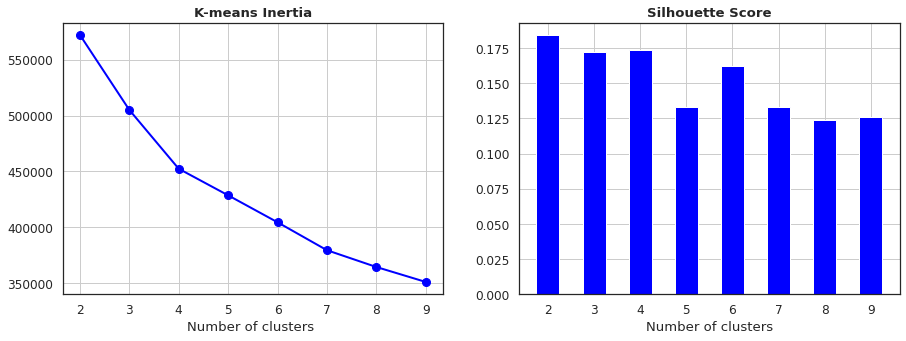

In [336]:
"""
Silhouette graph measures how tightly grouped the examples in the clusters are.
"""
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style = 'white', font_scale=1.1, rc={'figure.figsize': (15,5)})

plt.subplot(1,2,1)

plt.plot(range(2, len(inertia)+2), inertia, marker ='o', lw = 2, ms = 8, color = 'blue')
plt.xlabel('Number of clusters ')
plt.title('K-means Inertia', fontweight ='bold')
plt.grid(True)

plt.subplot(1,2,2)

plt.bar(range(len(silhouette)), list(silhouette.values()), align = 'center', color ='blue', width = 0.5)
plt.xticks(range(len(silhouette)), list(silhouette.keys()))
plt.grid()
plt.title('Silhouette Score', fontweight = 'bold')
plt.xlabel('Number of clusters')

plt.show()

> The above charts (Elbow Method, and Silhouette Chart) shows that the correct number of clusters for our dataset is 4. 

In [337]:
import sklearn.cluster as cluster
kmeans = cluster.KMeans(n_clusters = 4, random_state=17, init ='k-means++')
kmeans_labels = kmeans.fit_predict(df_crash_final)

centroids = kmeans.cluster_centers_
centroids_pca = pca_2.transform(centroids)
pd.Series(kmeans_labels).value_counts()

0    11650
1     8369
3     8112
2        1
dtype: int64

Text(0.5, 0, 'Principal Component 1')

Text(0, 0.5, 'Principal Component 2')

Text(0.5, 1.0, 'Clustered Data (PCA visualization)')

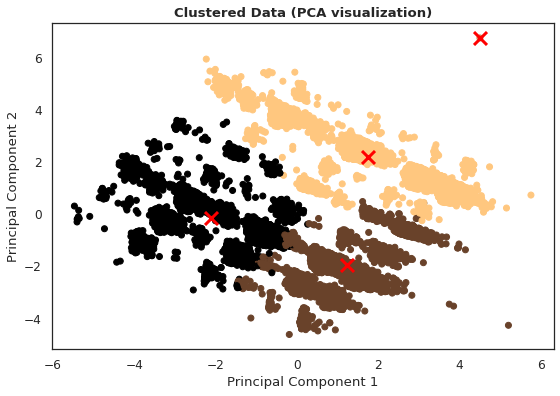

In [338]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white', rc={'figure.figsize':(9,6)},font_scale=1.1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], c=kmeans_labels, cmap='copper')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
            marker='x', s=169, linewidths=3,
            color='red', zorder=10,lw=3)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustered Data (PCA visualization)',fontweight='bold')
plt.show()

['POSTED_SPEED_LIMIT',
 'TRAFFIC_CONTROL_DEVICE',
 'LIGHTING_CONDITION',
 'FIRST_CRASH_TYPE',
 'TRAFFICWAY_TYPE',
 'ALIGNMENT',
 'ROADWAY_SURFACE_COND',
 'ROAD_DEFECT',
 'DAMAGE',
 'PRIM_CONTRIBUTORY_CAUSE',
 'STREET_DIRECTION',
 'NUM_UNITS',
 'MOST_SEVERE_INJURY',
 'CRASH_DAY_OF_WEEK',
 'LATITUDE',
 'LONGITUDE',
 'LIC_PLATE_STATE',
 'VEHICLE_YEAR',
 'VEHICLE_DEFECT',
 'VEHICLE_TYPE',
 'VEHICLE_USE',
 'STATE',
 'SEX',
 'AGE',
 'SAFETY_EQUIPMENT',
 'AIRBAG_DEPLOYED',
 'EJECTION',
 'DRIVER_VISION',
 'SEASONS',
 'CRASH_YEAR',
 'CRITICAL_INJURY',
 'FATAL_INJURY',
 'NON_CRITICAL_INJURY']

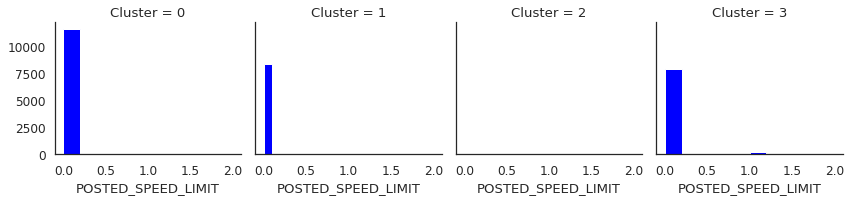

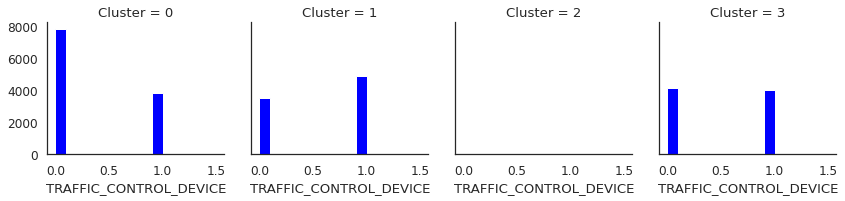

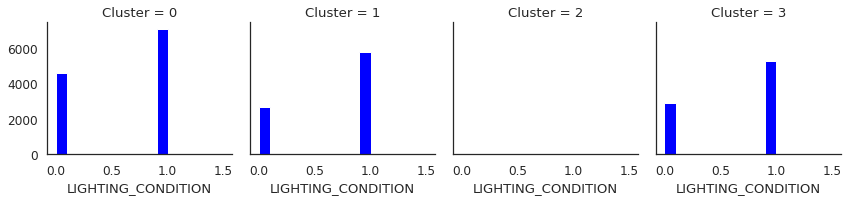

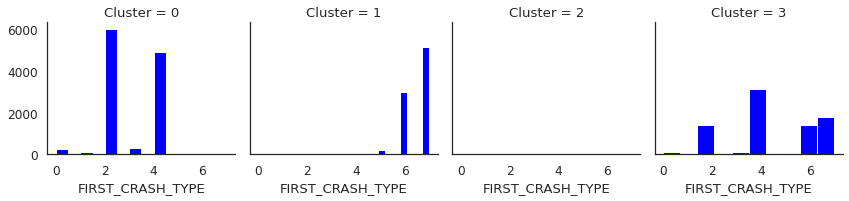

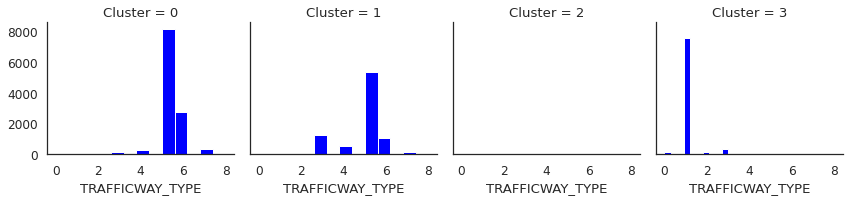

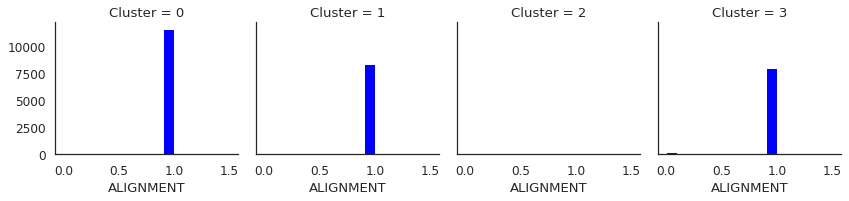

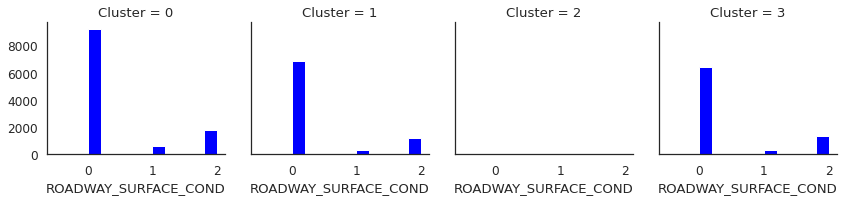

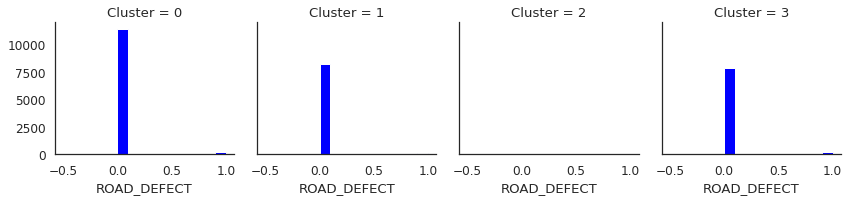

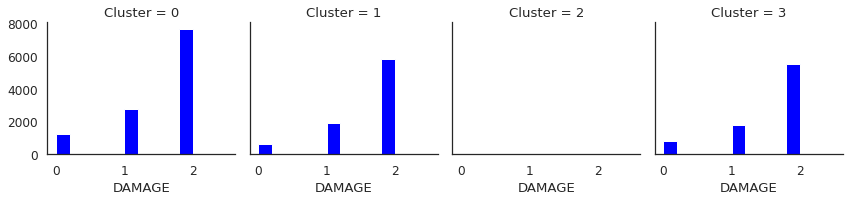

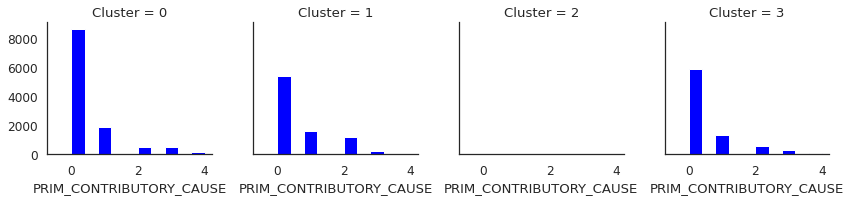

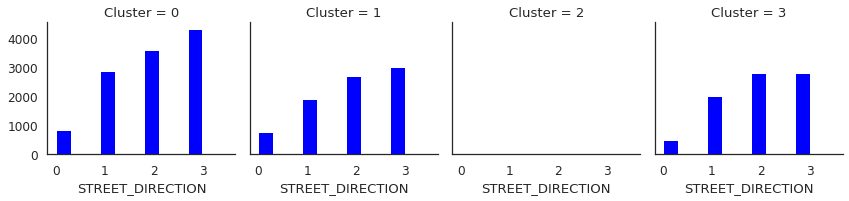

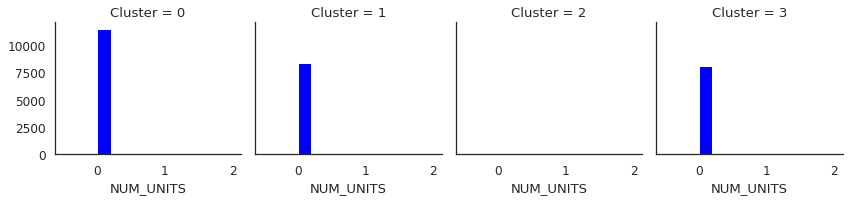

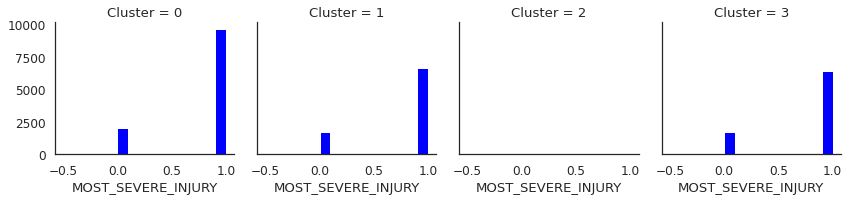

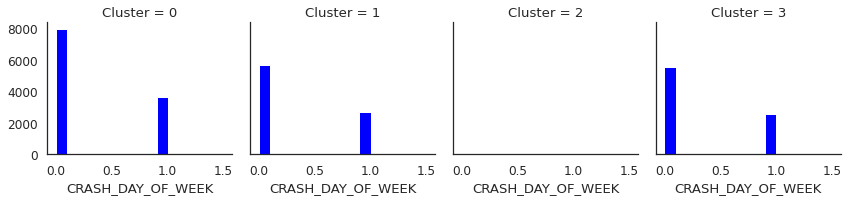

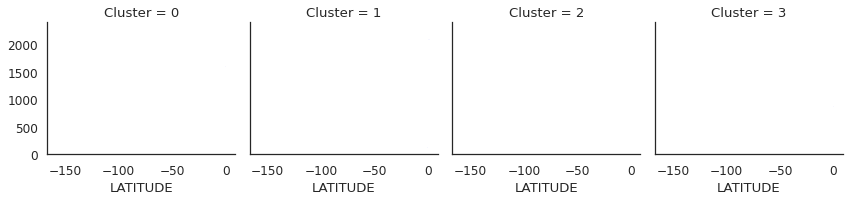

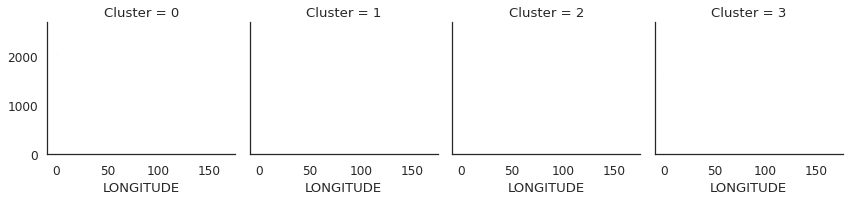

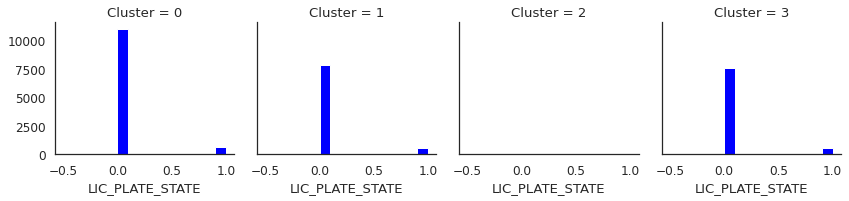

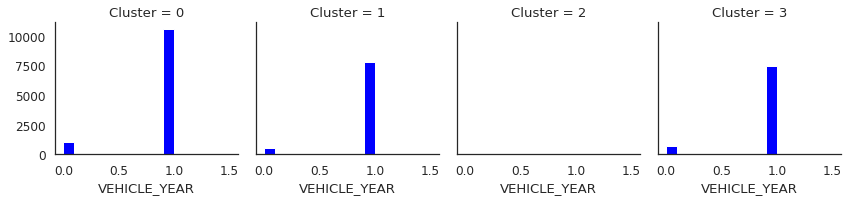

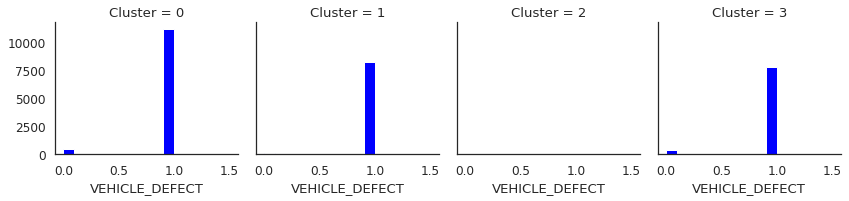

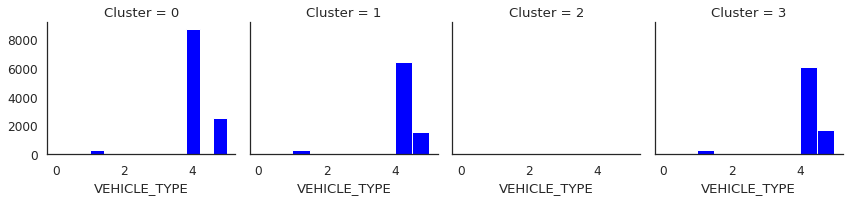

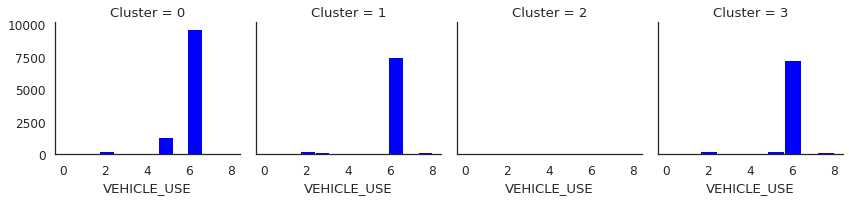

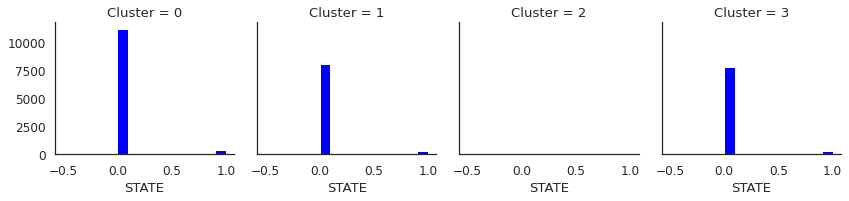

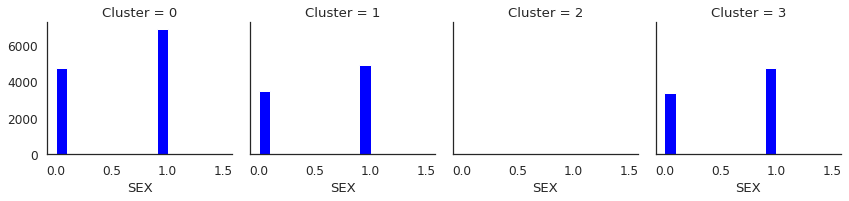

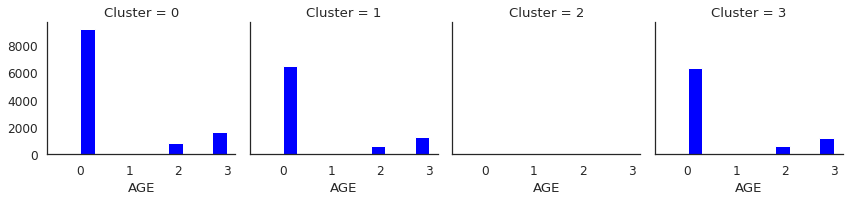

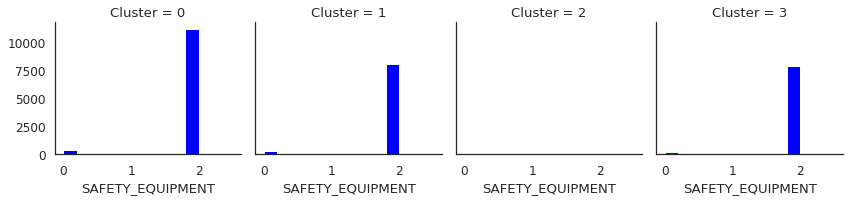

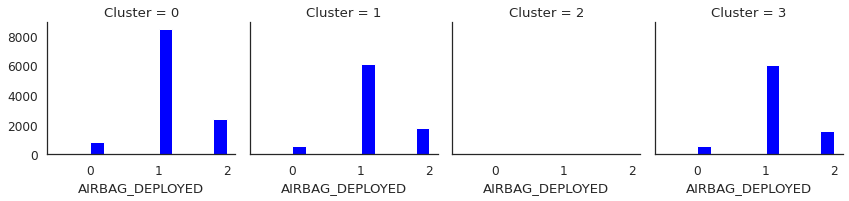

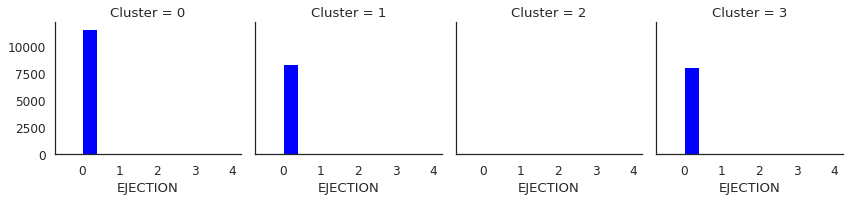

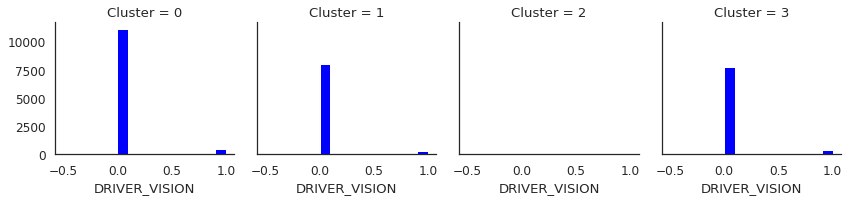

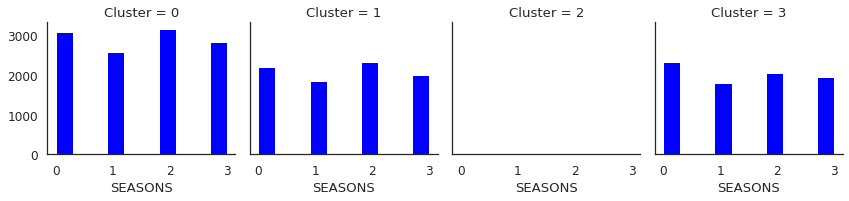

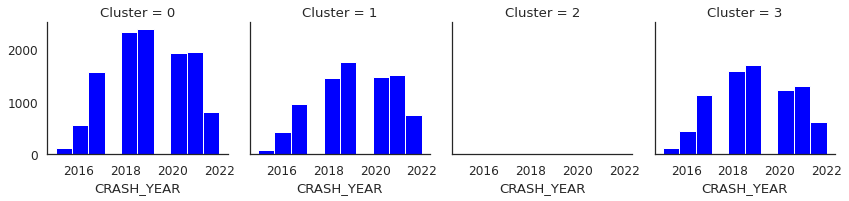

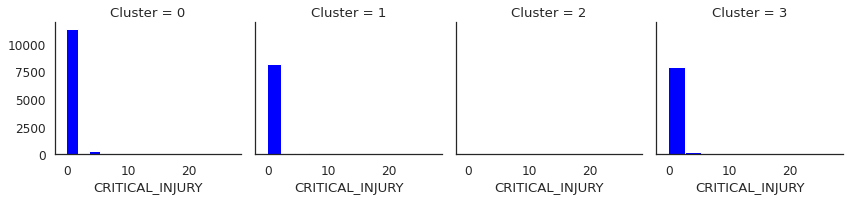

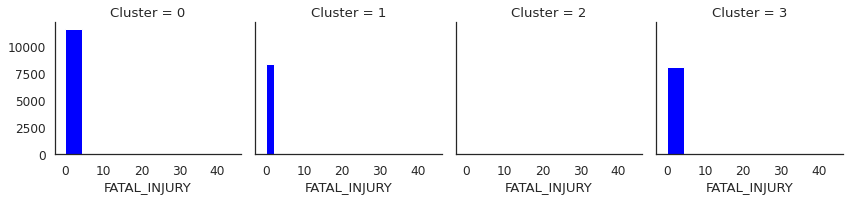

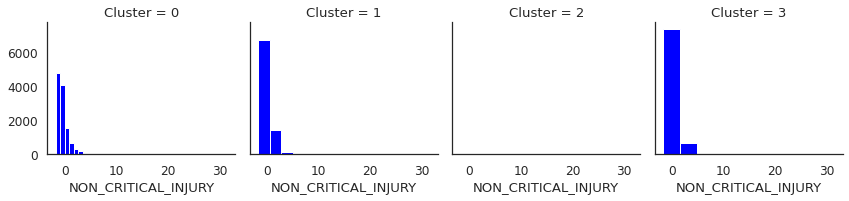

In [339]:
data2 = df_crash_final.copy()
data2['Cluster'] = kmeans_labels

aux = data2.columns.tolist()
aux[0:len(aux)-1]

for i in aux[0:len(aux)-1]:
  grid = sns.FacetGrid(data2, col = 'Cluster')
  grid.map(plt.hist, i,  color ='blue')

## Agglomerative Clustering

In [340]:
from sklearn.cluster import AgglomerativeClustering
#create the model that we want, setting the linkage to ward, the distance threshold to 6 and 
#set the number of clusters to none so that we can plot the dendrogram afterwards
model6 = AgglomerativeClustering(linkage="ward", 
                                 distance_threshold = 6, 
                                 n_clusters=None)
#fit the model to the data
model6.fit(df_crash_final)

#assign the labels back to the dataset
df_crash_final["Aggl_clus_6"] = model6.labels_

AgglomerativeClustering(distance_threshold=6, n_clusters=None)

Text(0.5, 1.0, 'Hierarchical clustering dendrogram')

Text(0.5, 0, 'Number of points in node')

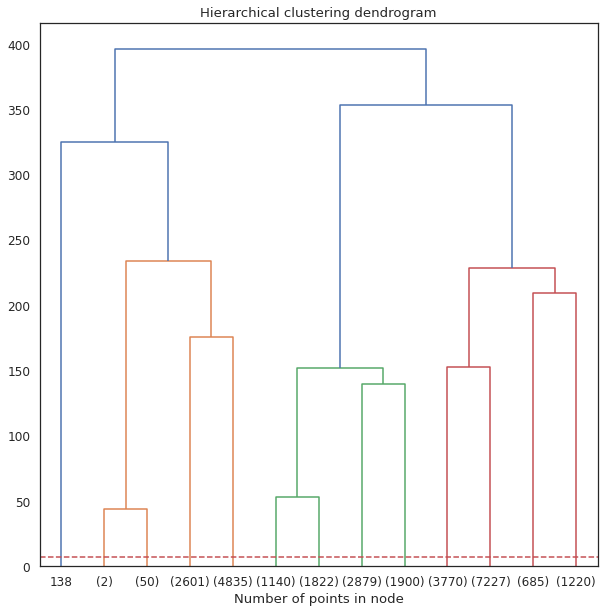

In [341]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram
import sys
limit = sys.getrecursionlimit()

sys.setrecursionlimit(limit)
def plot_dendrogram(model, **kwargs):
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count +=1
            else:
                current_count += counts[child_idx-n_samples]
        counts[i] = current_count
        
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                     counts]).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)

fig, ax = plt.subplots(figsize = (10,10))
ax.set_title("Hierarchical clustering dendrogram")
#plot the top three levels of the dendrogram
plot_dendrogram(model6, truncate_mode='level', p=3)
plt.axhline(y = 7, color = "r", linestyle = "--")
ax.set_xlabel("Number of points in node")
plt.show()

## DBSCAN

In [342]:
from sklearn.cluster import DBSCAN
import numpy as np
db = DBSCAN(eps = 0.2, min_samples=3, metric = 'euclidean')

y_db = db.fit_predict(df_crash_final)
np.unique(y_db)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [343]:

def hopkins(df,m):
    from sklearn.neighbors import NearestNeighbors
    from random import sample
    from pandas import DataFrame
    from numpy import random

    d = len(df.columns) # columns
    n = len(df) # rows
    
    df = (df - df.min())/(df.max()-df.min()) *2 -1
    df = df / df.std()
    

    knn = NearestNeighbors(n_neighbors=2).fit(df)

    rand_df = DataFrame(random.rand(m,d),index = range(0,m),columns =df.columns )
    rand_df = rand_df*2-1
    rand_df = rand_df * df.abs().max()

    ujd = []
    wjd = []

    for j in range(0, m):
        u_dist, _ = knn.kneighbors([rand_df.iloc[j]])
        ujd.append(u_dist[0][0])

        w_dist, _ = knn.kneighbors(df.sample(1))
        wjd.append(w_dist[0][1])

    return(sum(ujd) / (sum(ujd) + sum(wjd)))

m = 10
hopkins(df_crash_final,6)  

0.9683849033558161


While we were searching for a parameter to see if our data is clusterable we came across the below code about John Hopkins Statistics.

A value close to 1 tends to indicate the data is highly clustered, random data will tend to result in values around 0.5, and uniformly distributed data will tend to result in values close to 0.

From the above we can see that the John hopkins Statistic value is 0.97. Showing our data to be highly clusterable.

https://github.com/royjafari/DataAnalyticsForFun/blob/main/FeatureExtraction%2BClustering/Feature%20Extraction%20%2B%20Clustering%20-%20E.ipynb

# CONCLUSION:

> For this analysis we performed Clustering Analysis on the Chicago Crash data set using two types of Clustering: KMeans and Agglomertative Clustering.  We used the Elbow Method and Silhouette Plot to determine the number of clusters within the dataset. 

The dataset had too many dimensions to plot, therefore, in order to graph the clusters we performed PCA and used the dimensions from the PCA to graph the Kmeans Plot.

We found that the optimal number of Clusters for Kmeans was 4. Whereas for the Agglomertative Clusters, we saw that there were 13 Clusters.

DBCAN also produced 10 clusters.

Our data proves to be highlighy clusterable. 

Our next step would be to run some clasification methods using the clusters to see if we could produce a bench mark and improve that benchmark using the clusters to create new features. However, our time ran short and we weren't able to experiment.



